In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/OFTALMOLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=130.5, y1=139.9
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 322
Page 1, Q1, A: Yellow percentage: 0.0%


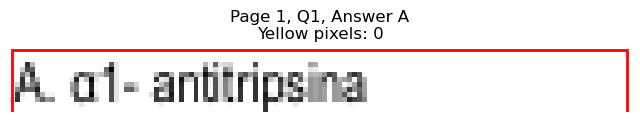

Page 1, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=133.5, y1=152.6
Page 1, Q1, B: Yellow pixels: 1351
Page 1, Q1, B: Total non-white pixels: 1792
Page 1, Q1, B: Yellow percentage: 75.4%


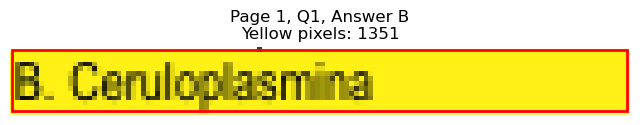

Page 1, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=363.2, y1=139.9
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 221
Page 1, Q1, C: Yellow percentage: 0.0%


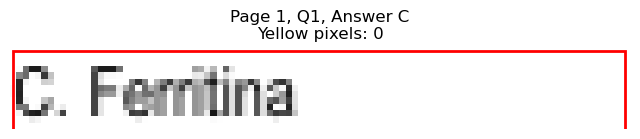

Page 1, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=362.1, y1=152.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 210
Page 1, Q1, D: Yellow percentage: 0.0%


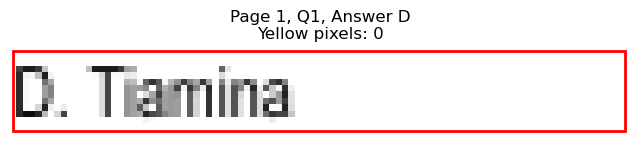


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=101.9, y1=190.4
Page 1, Q2, A: Yellow pixels: 96
Page 1, Q2, A: Total non-white pixels: 301
Page 1, Q2, A: Yellow percentage: 31.9%


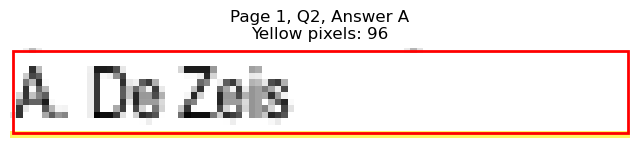

Page 1, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=101.4, y1=203.0
Page 1, Q2, B: Yellow pixels: 1080
Page 1, Q2, B: Total non-white pixels: 1248
Page 1, Q2, B: Yellow percentage: 86.5%


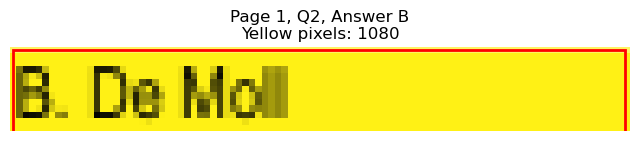

Page 1, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=351.7, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 173
Page 1, Q2, C: Yellow percentage: 0.0%


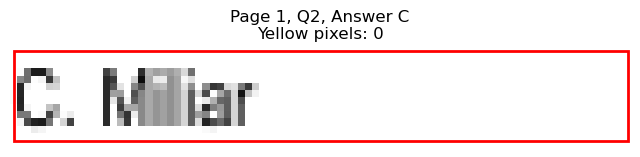

Page 1, Q2 - D: Detected box: x0=315.4, y0=606.9, x1=369.3, y1=619.5
Page 1, Q2, D: Yellow pixels: 1049
Page 1, Q2, D: Total non-white pixels: 1470
Page 1, Q2, D: Yellow percentage: 71.4%


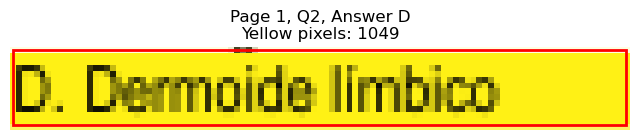


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=192.3, y1=266.1
Page 1, Q3, A: Yellow pixels: 1940
Page 1, Q3, A: Total non-white pixels: 2618
Page 1, Q3, A: Yellow percentage: 74.1%


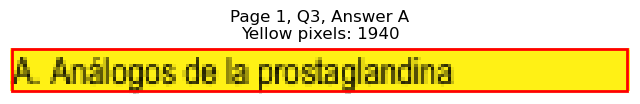

Page 1, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=198.6, y1=278.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 937
Page 1, Q3, B: Yellow percentage: 0.0%


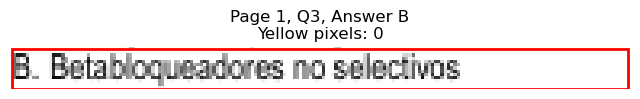

Page 1, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=480.1, y1=266.1
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 822
Page 1, Q3, C: Yellow percentage: 0.0%


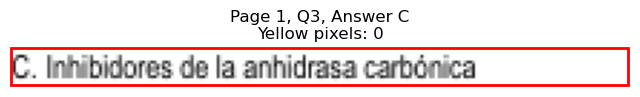

Page 1, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=462.4, y1=278.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 774
Page 1, Q3, D: Yellow percentage: 0.0%


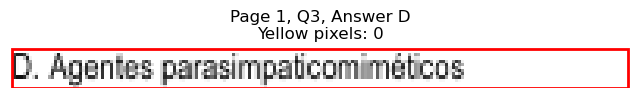


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=218.3, y1=316.6
Page 1, Q4, A: Yellow pixels: 2158
Page 1, Q4, A: Total non-white pixels: 2780
Page 1, Q4, A: Yellow percentage: 77.6%


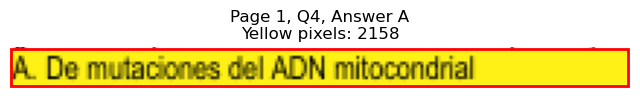

Page 1, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=214.2, y1=329.2
Page 1, Q4, B: Yellow pixels: 209
Page 1, Q4, B: Total non-white pixels: 963
Page 1, Q4, B: Yellow percentage: 21.7%


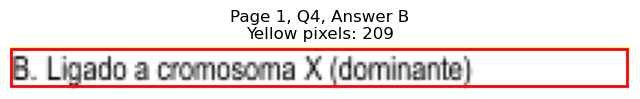

Page 1, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=440.9, y1=316.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 597
Page 1, Q4, C: Yellow percentage: 0.0%


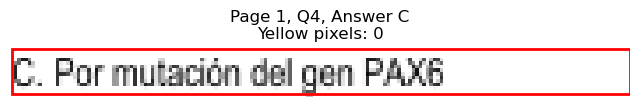

Page 1, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=464.9, y1=329.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 693
Page 1, Q4, D: Yellow percentage: 0.0%


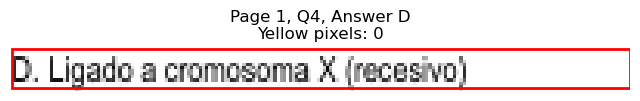


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=142.0, y1=392.4
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 360
Page 1, Q5, A: Yellow percentage: 0.0%


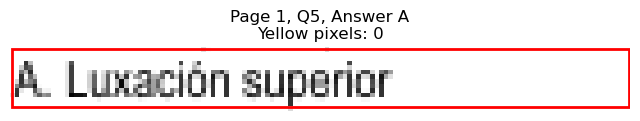

Page 1, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=193.2, y1=405.0
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 658
Page 1, Q5, B: Yellow percentage: 0.0%


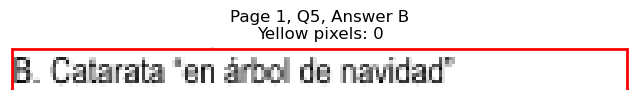

Page 1, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=442.4, y1=392.4
Page 1, Q5, C: Yellow pixels: 178
Page 1, Q5, C: Total non-white pixels: 763
Page 1, Q5, C: Yellow percentage: 23.3%


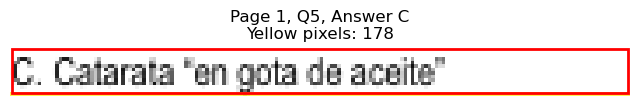

Page 1, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=402.3, y1=405.0
Page 1, Q5, D: Yellow pixels: 1497
Page 1, Q5, D: Total non-white pixels: 1794
Page 1, Q5, D: Yellow percentage: 83.4%


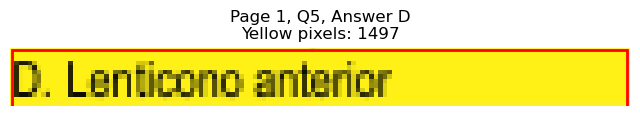


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=163.6, y1=455.5
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 526
Page 1, Q6, A: Yellow percentage: 0.0%


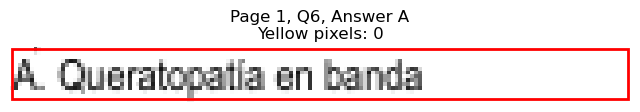

Page 1, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=160.1, y1=468.1
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 499
Page 1, Q6, B: Yellow percentage: 0.0%


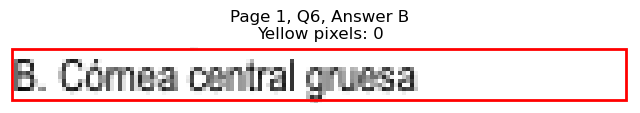

Page 1, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=390.8, y1=455.5
Page 1, Q6, C: Yellow pixels: 1373
Page 1, Q6, C: Total non-white pixels: 1764
Page 1, Q6, C: Yellow percentage: 77.8%


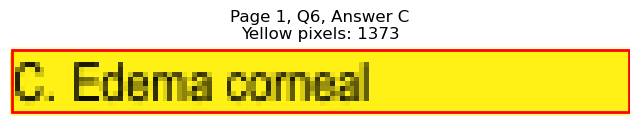

Page 1, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=368.7, y1=468.1
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 257
Page 1, Q6, D: Yellow percentage: 0.0%


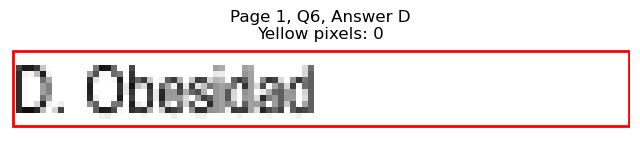


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=207.2, y1=518.6
Page 1, Q7, A: Yellow pixels: 2066
Page 1, Q7, A: Total non-white pixels: 2828
Page 1, Q7, A: Yellow percentage: 73.1%


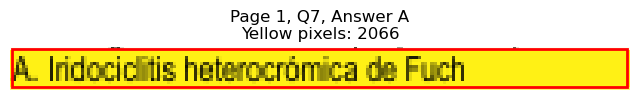

Page 1, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=238.4, y1=531.2
Page 1, Q7, B: Yellow pixels: 225
Page 1, Q7, B: Total non-white pixels: 1078
Page 1, Q7, B: Yellow percentage: 20.9%


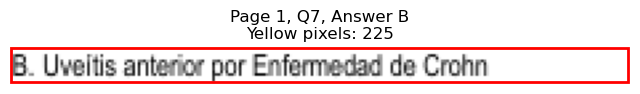

Page 1, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=453.9, y1=518.6
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 704
Page 1, Q7, C: Yellow percentage: 0.0%


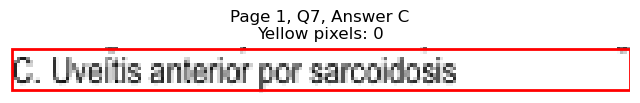

Page 1, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=404.8, y1=531.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 440
Page 1, Q7, D: Yellow percentage: 0.0%


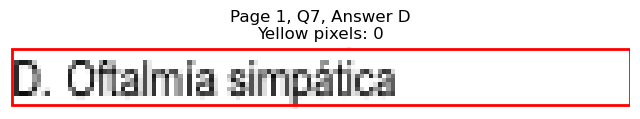


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=112.5, y1=569.1
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 263
Page 1, Q8, A: Yellow percentage: 0.0%


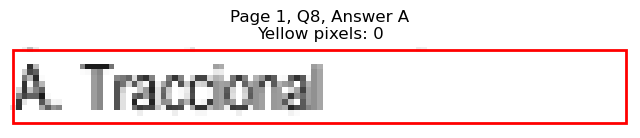

Page 1, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=127.5, y1=581.7
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 368
Page 1, Q8, B: Yellow percentage: 0.0%


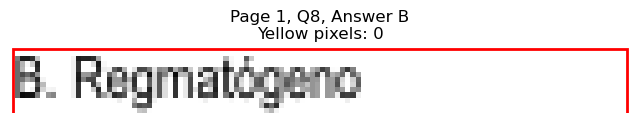

Page 1, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=383.2, y1=569.1
Page 1, Q8, C: Yellow pixels: 119
Page 1, Q8, C: Total non-white pixels: 454
Page 1, Q8, C: Yellow percentage: 26.2%


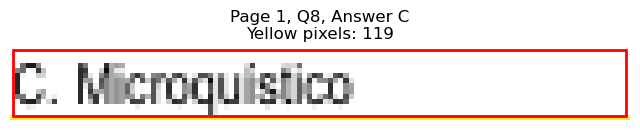

Page 1, Q8 - D: Detected box: x0=315.4, y0=569.1, x1=369.7, y1=581.7
Page 1, Q8, D: Yellow pixels: 1170
Page 1, Q8, D: Total non-white pixels: 1365
Page 1, Q8, D: Yellow percentage: 85.7%


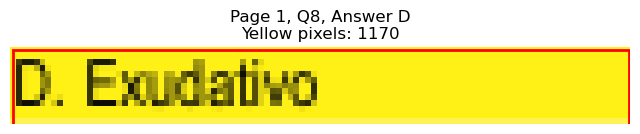


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=594.3, x1=141.5, y1=606.9
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 419
Page 1, Q9, A: Yellow percentage: 0.0%


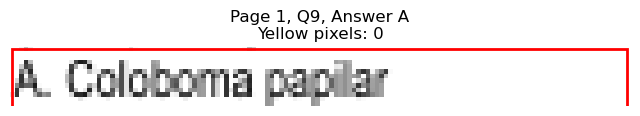

Page 1, Q9 - B: Detected box: x0=56.6, y0=606.9, x1=149.5, y1=619.5
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 454
Page 1, Q9, B: Yellow percentage: 0.0%


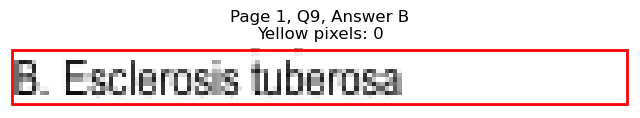

Page 1, Q9 - C: Detected box: x0=315.4, y0=594.3, x1=379.3, y1=606.9
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 396
Page 1, Q9, C: Yellow percentage: 0.0%


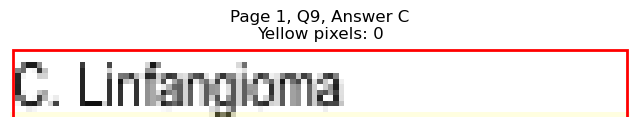

Page 1, Q9 - D: Detected box: x0=315.4, y0=606.9, x1=400.3, y1=619.5
Page 1, Q9, D: Yellow pixels: 1452
Page 1, Q9, D: Total non-white pixels: 1904
Page 1, Q9, D: Yellow percentage: 76.3%


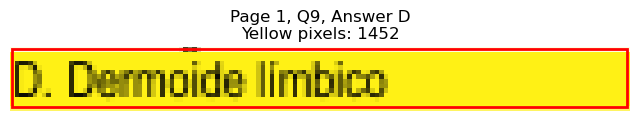


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=644.8, x1=125.4, y1=657.5
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 331
Page 1, Q10, A: Yellow percentage: 0.0%


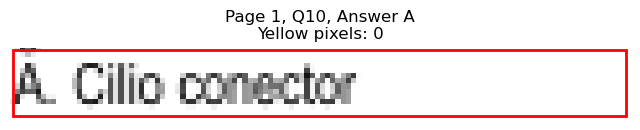

Page 1, Q10 - B: Detected box: x0=56.6, y0=657.4, x1=199.7, y1=670.1
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 712
Page 1, Q10, B: Yellow percentage: 0.0%


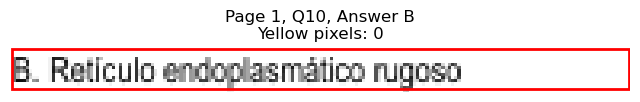

Page 1, Q10 - C: Detected box: x0=315.4, y0=644.8, x1=376.7, y1=657.5
Page 1, Q10, C: Yellow pixels: 1215
Page 1, Q10, C: Total non-white pixels: 1568
Page 1, Q10, C: Yellow percentage: 77.5%


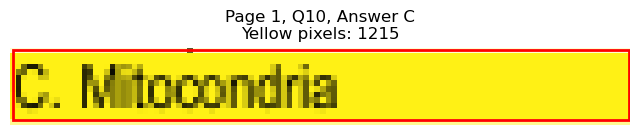

Page 1, Q10 - D: Detected box: x0=315.4, y0=657.4, x1=391.7, y1=670.1
Page 1, Q10, D: Yellow pixels: 127
Page 1, Q10, D: Total non-white pixels: 488
Page 1, Q10, D: Yellow percentage: 26.0%


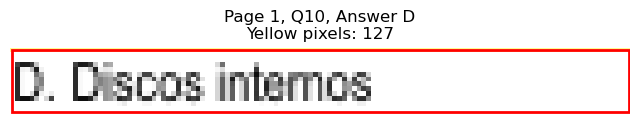


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)
Page 1, Q11 - A: Detected box: x0=56.6, y0=695.4, x1=126.0, y1=708.0
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 309
Page 1, Q11, A: Yellow percentage: 0.0%


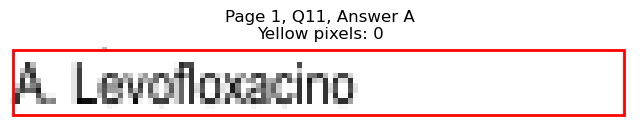

Page 1, Q11 - B: Detected box: x0=56.6, y0=708.0, x1=109.5, y1=720.6
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 272
Page 1, Q11, B: Yellow percentage: 0.0%


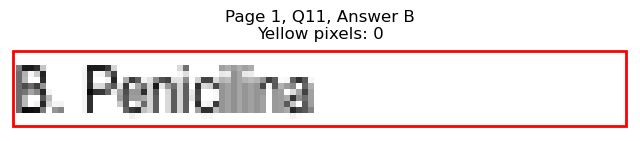

Page 1, Q11 - C: Detected box: x0=315.4, y0=695.4, x1=363.7, y1=708.0
Page 1, Q11, C: Yellow pixels: 99
Page 1, Q11, C: Total non-white pixels: 418
Page 1, Q11, C: Yellow percentage: 23.7%


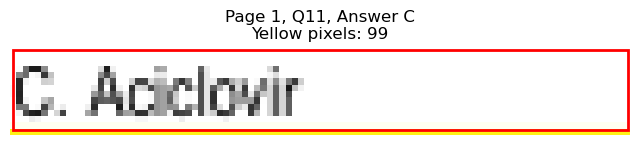

Page 1, Q11 - D: Detected box: x0=315.4, y0=708.0, x1=380.3, y1=720.6
Page 1, Q11, D: Yellow pixels: 1264
Page 1, Q11, D: Total non-white pixels: 1624
Page 1, Q11, D: Yellow percentage: 77.8%


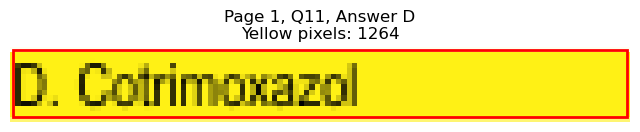


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)

Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=107.4, y1=127.3
Page 2, Q1, A: Yellow pixels: 102
Page 2, Q1, A: Total non-white pixels: 331
Page 2, Q1, A: Yellow percentage: 30.8%


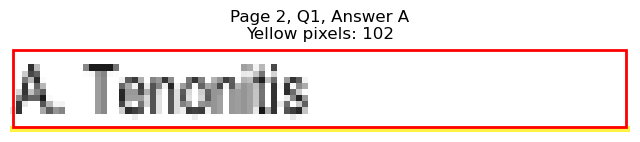

Page 2, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=117.5, y1=139.9
Page 2, Q1, B: Yellow pixels: 1201
Page 2, Q1, B: Total non-white pixels: 1456
Page 2, Q1, B: Yellow percentage: 82.5%


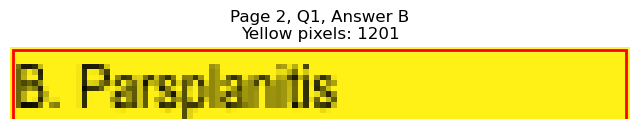

Page 2, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=371.7, y1=127.3
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 286
Page 2, Q1, C: Yellow percentage: 0.0%


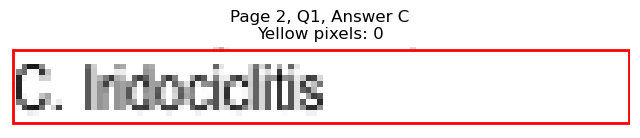

Page 2, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=403.7, y1=139.9
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 444
Page 2, Q1, D: Yellow percentage: 0.0%


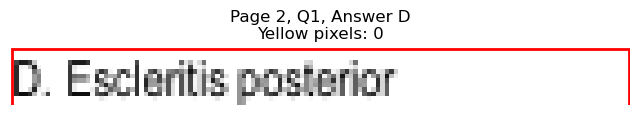


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=185.7, y1=190.4
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 610
Page 2, Q2, A: Yellow percentage: 0.0%


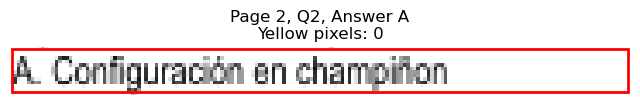

Page 2, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=156.0, y1=203.0
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 487
Page 2, Q2, B: Yellow percentage: 0.0%


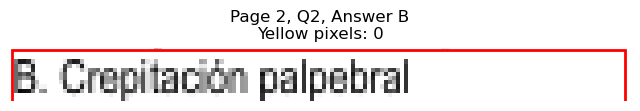

Page 2, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=399.8, y1=190.4
Page 2, Q2, C: Yellow pixels: 1335
Page 2, Q2, C: Total non-white pixels: 1890
Page 2, Q2, C: Yellow percentage: 70.6%


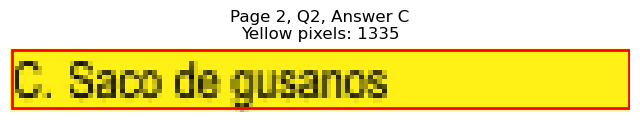

Page 2, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=412.7, y1=203.0
Page 2, Q2, D: Yellow pixels: 2
Page 2, Q2, D: Total non-white pixels: 644
Page 2, Q2, D: Yellow percentage: 0.3%


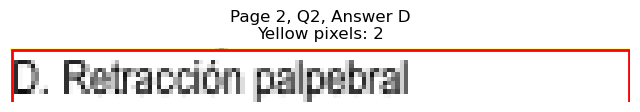


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=230.8, y1=240.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 880
Page 2, Q3, A: Yellow percentage: 0.0%


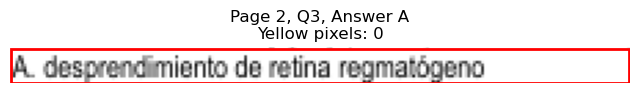

Page 2, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=216.3, y1=253.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 798
Page 2, Q3, B: Yellow percentage: 0.0%


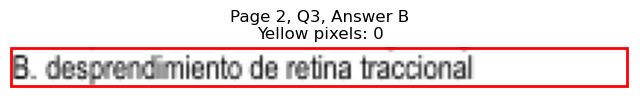

Page 2, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=464.0, y1=240.9
Page 2, Q3, C: Yellow pixels: 2027
Page 2, Q3, C: Total non-white pixels: 2587
Page 2, Q3, C: Yellow percentage: 78.4%


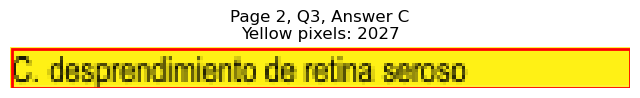

Page 2, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=380.2, y1=253.5
Page 2, Q3, D: Yellow pixels: 115
Page 2, Q3, D: Total non-white pixels: 446
Page 2, Q3, D: Yellow percentage: 25.8%


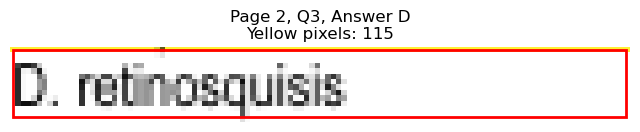


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=278.8, x1=111.4, y1=291.4
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 263
Page 2, Q4, A: Yellow percentage: 0.0%


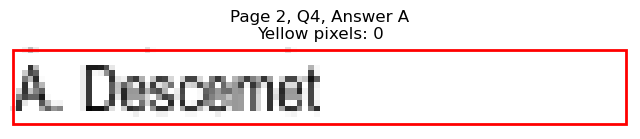

Page 2, Q4 - B: Detected box: x0=56.6, y0=291.4, x1=105.9, y1=304.0
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 217
Page 2, Q4, B: Yellow percentage: 0.0%


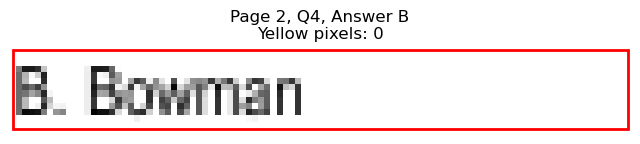

Page 2, Q4 - C: Detected box: x0=315.4, y0=278.8, x1=363.7, y1=291.4
Page 2, Q4, C: Yellow pixels: 1129
Page 2, Q4, C: Total non-white pixels: 1386
Page 2, Q4, C: Yellow percentage: 81.5%


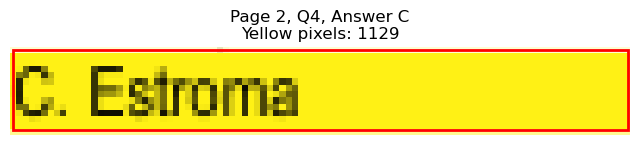

Page 2, Q4 - D: Detected box: x0=315.4, y0=291.4, x1=367.6, y1=304.0
Page 2, Q4, D: Yellow pixels: 103
Page 2, Q4, D: Total non-white pixels: 349
Page 2, Q4, D: Yellow percentage: 29.5%


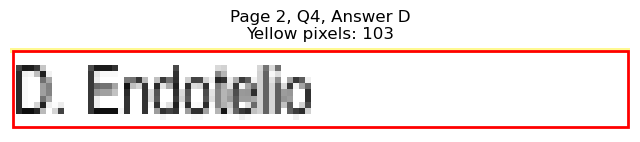


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=329.2, x1=109.9, y1=341.8
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 236
Page 2, Q5, A: Yellow percentage: 0.0%


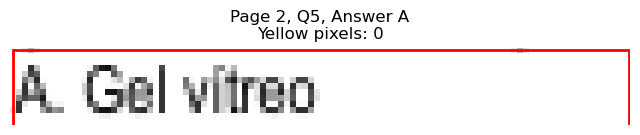

Page 2, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=154.6, y1=354.6
Page 2, Q5, B: Yellow pixels: 1558
Page 2, Q5, B: Total non-white pixels: 2086
Page 2, Q5, B: Yellow percentage: 74.7%


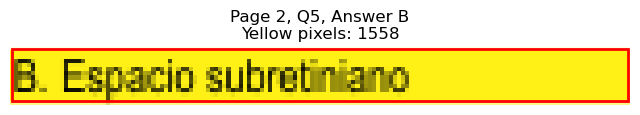

Page 2, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=395.2, y1=341.8
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 360
Page 2, Q5, C: Yellow percentage: 0.0%


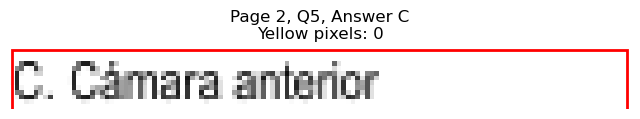

Page 2, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=419.3, y1=354.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 526
Page 2, Q5, D: Yellow percentage: 0.0%


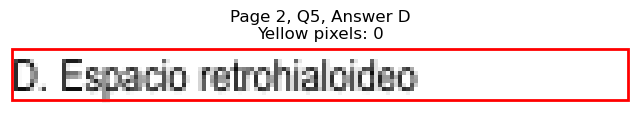


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=379.7, x1=363.8, y1=392.4
Page 2, Q6, A: Yellow pixels: 358
Page 2, Q6, A: Total non-white pixels: 1875
Page 2, Q6, A: Yellow percentage: 19.1%


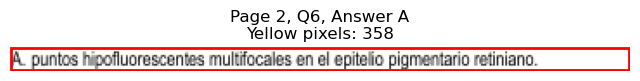

Page 2, Q6 - B: Detected box: x0=56.6, y0=392.3, x1=351.2, y1=405.0
Page 2, Q6, B: Yellow pixels: 3339
Page 2, Q6, B: Total non-white pixels: 4498
Page 2, Q6, B: Yellow percentage: 74.2%


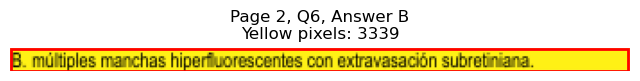

Page 2, Q6 - C: Detected box: x0=56.6, y0=404.9, x1=292.5, y1=417.6
Page 2, Q6, C: Yellow pixels: 285
Page 2, Q6, C: Total non-white pixels: 1442
Page 2, Q6, C: Yellow percentage: 19.8%


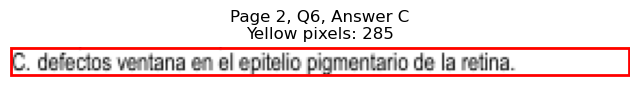

Page 2, Q6 - D: Detected box: x0=56.6, y0=417.6, x1=210.8, y1=430.3
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 710
Page 2, Q6, D: Yellow percentage: 0.0%


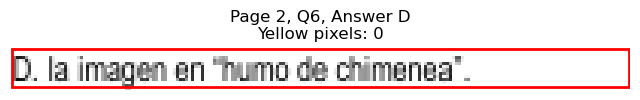


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=455.5, x1=146.5, y1=468.1
Page 2, Q7, A: Yellow pixels: 1478
Page 2, Q7, A: Total non-white pixels: 1974
Page 2, Q7, A: Yellow percentage: 74.9%


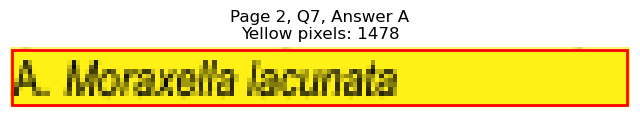

Page 2, Q7 - B: Detected box: x0=56.6, y0=468.1, x1=150.0, y1=480.7
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 591
Page 2, Q7, B: Yellow percentage: 0.0%


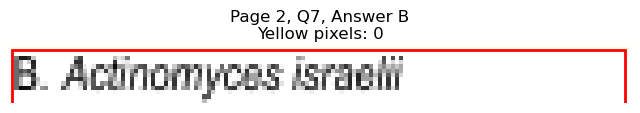

Page 2, Q7 - C: Detected box: x0=315.4, y0=455.5, x1=421.9, y1=468.1
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 526
Page 2, Q7, C: Yellow percentage: 0.0%


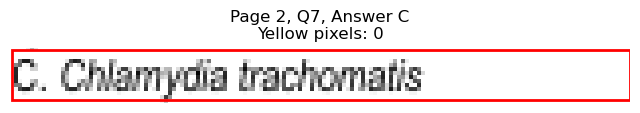

Page 2, Q7 - D: Detected box: x0=315.4, y0=468.1, x1=412.3, y1=480.7
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 465
Page 2, Q7, D: Yellow percentage: 0.0%


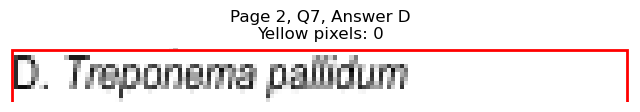


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=200.3, y1=569.1
Page 2, Q8, A: Yellow pixels: 195
Page 2, Q8, A: Total non-white pixels: 913
Page 2, Q8, A: Yellow percentage: 21.4%


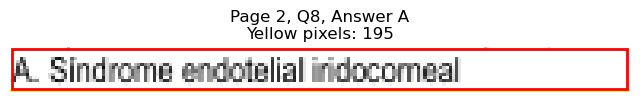

Page 2, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=194.7, y1=581.7
Page 2, Q8, B: Yellow pixels: 1910
Page 2, Q8, B: Total non-white pixels: 2457
Page 2, Q8, B: Yellow percentage: 77.7%


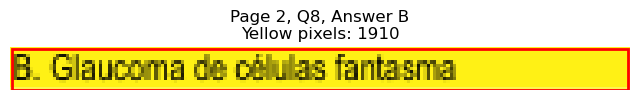

Page 2, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=415.9, y1=569.1
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 466
Page 2, Q8, C: Yellow percentage: 0.0%


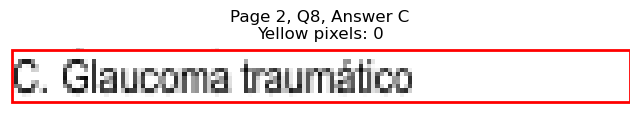

Page 2, Q8 - D: Detected box: x0=315.4, y0=569.1, x1=494.0, y1=581.7
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 853
Page 2, Q8, D: Yellow percentage: 0.0%


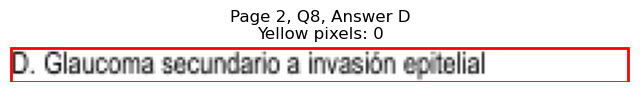


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=514.7, y1=619.5
Page 2, Q9, A: Yellow pixels: 4658
Page 2, Q9, A: Total non-white pixels: 6789
Page 2, Q9, A: Yellow percentage: 68.6%


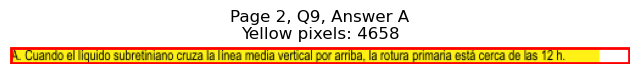

Page 2, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=514.7, y1=632.3
Page 2, Q9, B: Yellow pixels: 484
Page 2, Q9, B: Total non-white pixels: 2684
Page 2, Q9, B: Yellow percentage: 18.0%


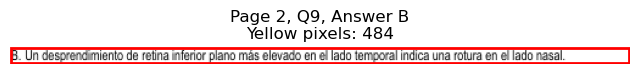

Page 2, Q9 - C: Detected box: x0=56.6, y0=632.2, x1=458.5, y1=644.9
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 1915
Page 2, Q9, C: Yellow percentage: 0.0%


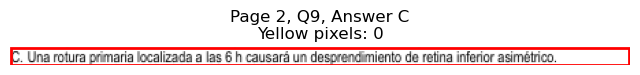

Page 2, Q9 - D: Detected box: x0=56.6, y0=644.8, x1=528.7, y1=657.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 2272
Page 2, Q9, D: Yellow percentage: 0.0%


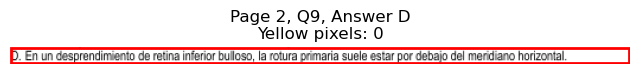


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)
Page 2, Q10 - A: Detected box: x0=56.6, y0=682.6, x1=150.5, y1=695.3
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 486
Page 2, Q10, A: Yellow percentage: 0.0%


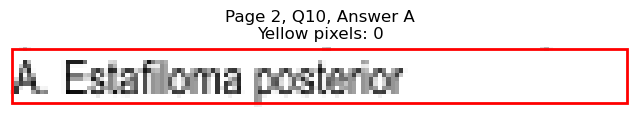

Page 2, Q10 - B: Detected box: x0=56.6, y0=695.4, x1=197.2, y1=708.0
Page 2, Q10, B: Yellow pixels: 1983
Page 2, Q10, B: Total non-white pixels: 2497
Page 2, Q10, B: Yellow percentage: 79.4%


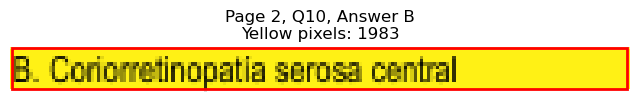

Page 2, Q10 - C: Detected box: x0=315.4, y0=682.6, x1=382.3, y1=695.3
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 305
Page 2, Q10, C: Yellow percentage: 0.0%


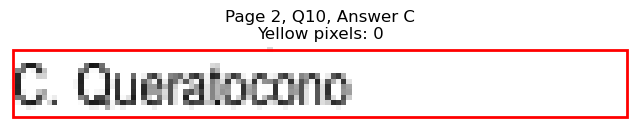

Page 2, Q10 - D: Detected box: x0=315.4, y0=695.4, x1=384.7, y1=708.0
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 364
Page 2, Q10, D: Yellow percentage: 0.0%


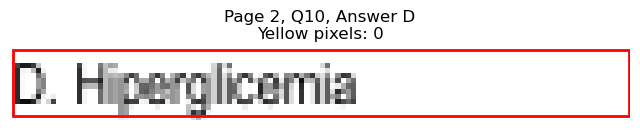


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)
Page 2, Q11 - A: Detected box: x0=56.6, y0=733.2, x1=176.2, y1=745.8
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 566
Page 2, Q11, A: Yellow percentage: 0.0%


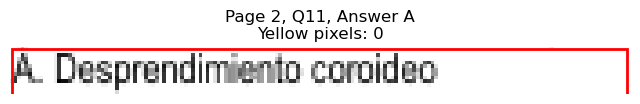

Page 2, Q11 - B: Detected box: x0=56.6, y0=745.8, x1=155.5, y1=758.4
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 463
Page 2, Q11, B: Yellow percentage: 0.0%


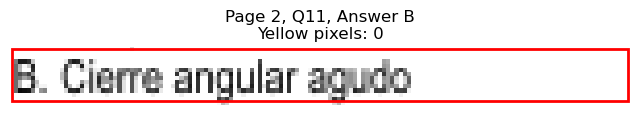

Page 2, Q11 - C: Detected box: x0=315.4, y0=733.2, x1=403.3, y1=745.8
Page 2, Q11, C: Yellow pixels: 0
Page 2, Q11, C: Total non-white pixels: 582
Page 2, Q11, C: Yellow percentage: 0.0%


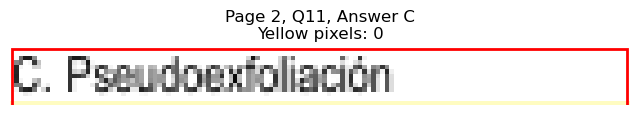

Page 2, Q11 - D: Detected box: x0=315.4, y0=745.8, x1=408.8, y1=758.4
Page 2, Q11, D: Yellow pixels: 1528
Page 2, Q11, D: Total non-white pixels: 2016
Page 2, Q11, D: Yellow percentage: 75.8%


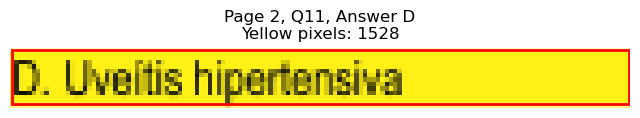


Page 2, Q11 - Selected Answer: D (based on yellow pixel count)

Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=182.7, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 620
Page 3, Q1, A: Yellow percentage: 0.0%


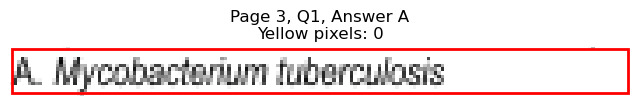

Page 3, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=153.0, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 459
Page 3, Q1, B: Yellow percentage: 0.0%


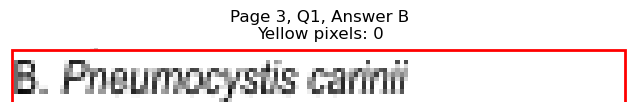

Page 3, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=391.3, y1=127.3
Page 3, Q1, C: Yellow pixels: 1275
Page 3, Q1, C: Total non-white pixels: 1778
Page 3, Q1, C: Yellow percentage: 71.7%


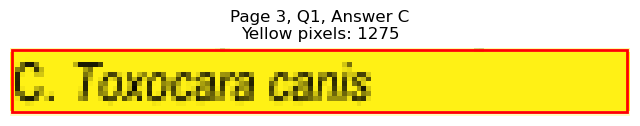

Page 3, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=434.8, y1=139.9
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 733
Page 3, Q1, D: Yellow percentage: 0.0%


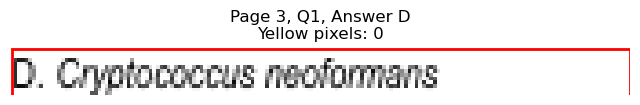


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=382.3, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 1640
Page 3, Q2, A: Yellow percentage: 0.0%


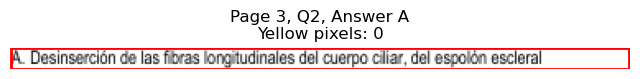

Page 3, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=264.9, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 959
Page 3, Q2, B: Yellow percentage: 0.0%


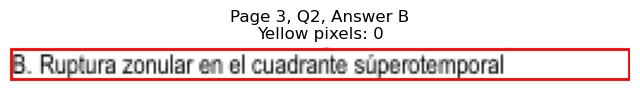

Page 3, Q2 - C: Detected box: x0=56.6, y0=190.3, x1=303.0, y1=203.0
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 1473
Page 3, Q2, C: Yellow percentage: 0.0%


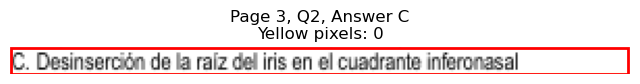

Page 3, Q2 - D: Detected box: x0=56.6, y0=202.9, x1=350.7, y1=215.6
Page 3, Q2, D: Yellow pixels: 3343
Page 3, Q2, D: Total non-white pixels: 4830
Page 3, Q2, D: Yellow percentage: 69.2%


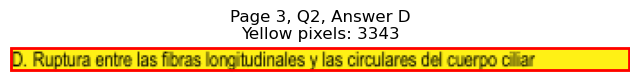


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=437.6, y1=253.5
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 1881
Page 3, Q3, A: Yellow percentage: 0.0%


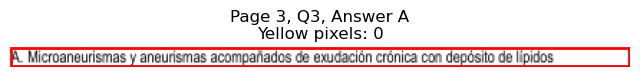

Page 3, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=533.3, y1=266.1
Page 3, Q3, B: Yellow pixels: 484
Page 3, Q3, B: Total non-white pixels: 2847
Page 3, Q3, B: Yellow percentage: 17.0%


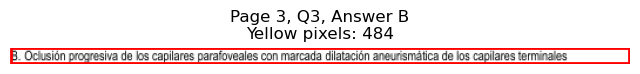

Page 3, Q3 - C: Detected box: x0=56.6, y0=266.0, x1=499.2, y1=278.7
Page 3, Q3, C: Yellow pixels: 4558
Page 3, Q3, C: Total non-white pixels: 6305
Page 3, Q3, C: Yellow percentage: 72.3%


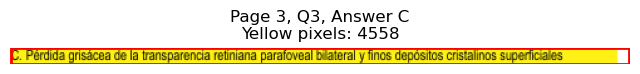

Page 3, Q3 - D: Detected box: x0=56.6, y0=278.8, x1=540.9, y1=291.4
Page 3, Q3, D: Yellow pixels: 481
Page 3, Q3, D: Total non-white pixels: 2831
Page 3, Q3, D: Yellow percentage: 17.0%


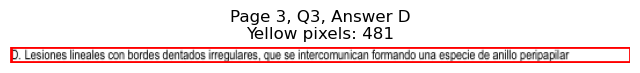


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=103.9, y1=329.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 230
Page 3, Q4, A: Yellow percentage: 0.0%


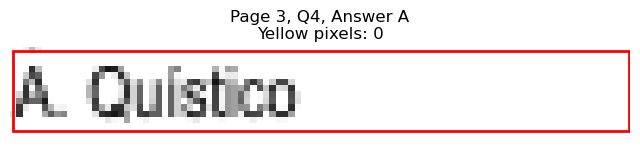

Page 3, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=121.5, y1=341.8
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 328
Page 3, Q4, B: Yellow percentage: 0.0%


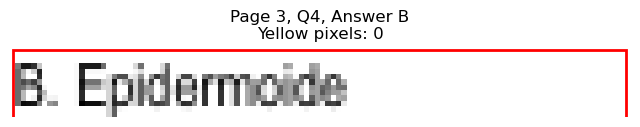

Page 3, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=372.7, y1=329.2
Page 3, Q4, C: Yellow pixels: 108
Page 3, Q4, C: Total non-white pixels: 365
Page 3, Q4, C: Yellow percentage: 29.6%


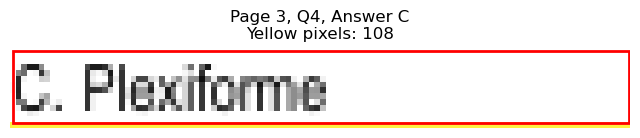

Page 3, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=377.7, y1=341.8
Page 3, Q4, D: Yellow pixels: 1254
Page 3, Q4, D: Total non-white pixels: 1469
Page 3, Q4, D: Yellow percentage: 85.4%


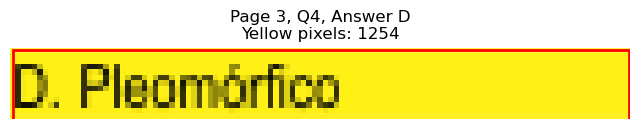


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=171.1, y1=417.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 553
Page 3, Q5, A: Yellow percentage: 0.0%


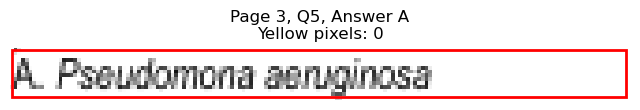

Page 3, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=167.1, y1=430.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 539
Page 3, Q5, B: Yellow percentage: 0.0%


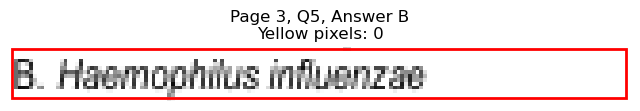

Page 3, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=445.9, y1=417.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 642
Page 3, Q5, C: Yellow percentage: 0.0%


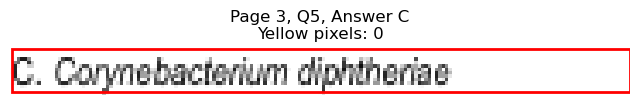

Page 3, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=429.3, y1=430.3
Page 3, Q5, D: Yellow pixels: 1551
Page 3, Q5, D: Total non-white pixels: 2310
Page 3, Q5, D: Yellow percentage: 67.1%


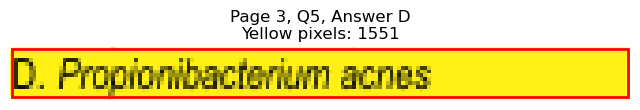


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=169.1, y1=493.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 547
Page 3, Q6, A: Yellow percentage: 0.0%


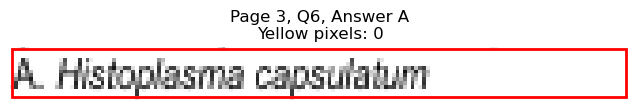

Page 3, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=146.5, y1=506.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 440
Page 3, Q6, B: Yellow percentage: 0.0%


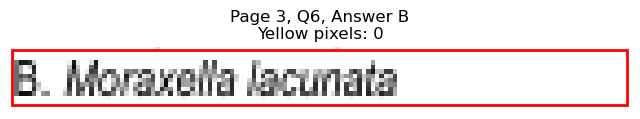

Page 3, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=409.9, y1=493.4
Page 3, Q6, C: Yellow pixels: 1370
Page 3, Q6, C: Total non-white pixels: 2030
Page 3, Q6, C: Yellow percentage: 67.5%


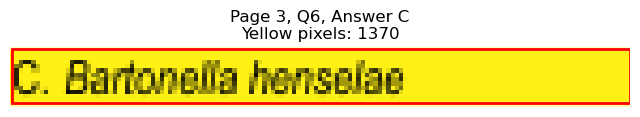

Page 3, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=405.4, y1=506.0
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 587
Page 3, Q6, D: Yellow percentage: 0.0%


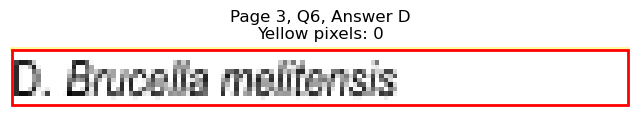


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=109.5, y1=543.8
Page 3, Q7, A: Yellow pixels: 1161
Page 3, Q7, A: Total non-white pixels: 1352
Page 3, Q7, A: Yellow percentage: 85.9%


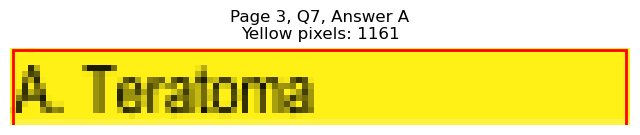

Page 3, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=118.0, y1=556.4
Page 3, Q7, B: Yellow pixels: 112
Page 3, Q7, B: Total non-white pixels: 395
Page 3, Q7, B: Yellow percentage: 28.4%


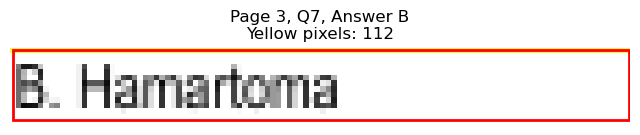

Page 3, Q7 - C: Detected box: x0=315.4, y0=531.2, x1=371.2, y1=543.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 262
Page 3, Q7, C: Yellow percentage: 0.0%


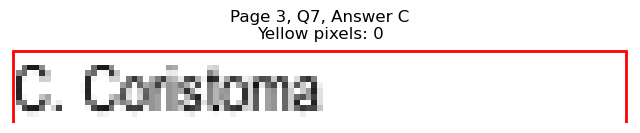

Page 3, Q7 - D: Detected box: x0=315.4, y0=543.8, x1=379.1, y1=556.4
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 324
Page 3, Q7, D: Yellow percentage: 0.0%


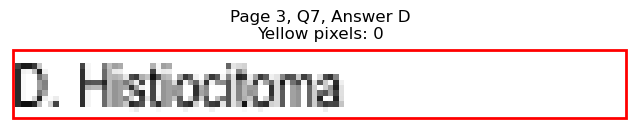


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=594.3, x1=109.0, y1=606.9
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 231
Page 3, Q8, A: Yellow percentage: 0.0%


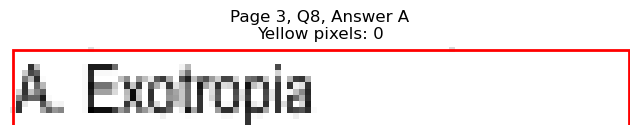

Page 3, Q8 - B: Detected box: x0=56.6, y0=606.9, x1=95.4, y1=619.5
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 172
Page 3, Q8, B: Yellow percentage: 0.0%


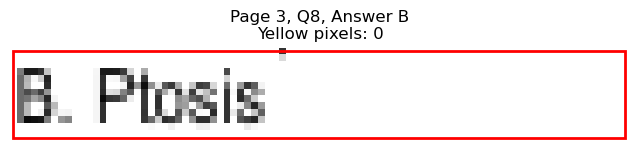

Page 3, Q8 - C: Detected box: x0=315.4, y0=594.3, x1=371.2, y1=606.9
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 377
Page 3, Q8, C: Yellow percentage: 0.0%


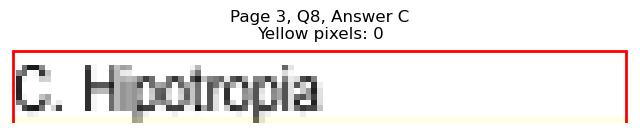

Page 3, Q8 - D: Detected box: x0=315.4, y0=606.9, x1=365.7, y1=619.5
Page 3, Q8, D: Yellow pixels: 1110
Page 3, Q8, D: Total non-white pixels: 1414
Page 3, Q8, D: Yellow percentage: 78.5%


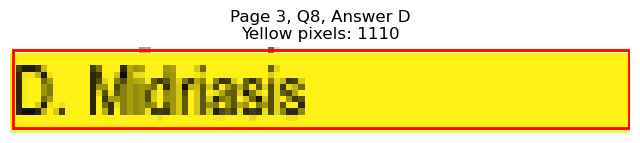


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=141.5, y1=657.5
Page 3, Q9, A: Yellow pixels: 1439
Page 3, Q9, A: Total non-white pixels: 1904
Page 3, Q9, A: Yellow percentage: 75.6%


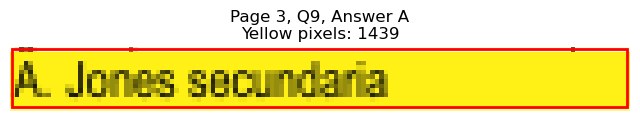

Page 3, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=130.0, y1=670.1
Page 3, Q9, B: Yellow pixels: 124
Page 3, Q9, B: Total non-white pixels: 458
Page 3, Q9, B: Yellow percentage: 27.1%


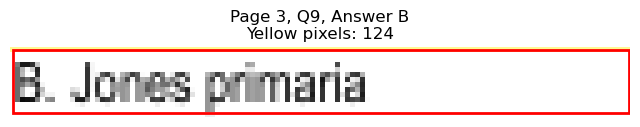

Page 3, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=459.5, y1=657.5
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 731
Page 3, Q9, C: Yellow percentage: 0.0%


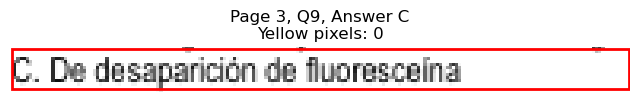

Page 3, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=413.8, y1=670.1
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 484
Page 3, Q9, D: Yellow percentage: 0.0%


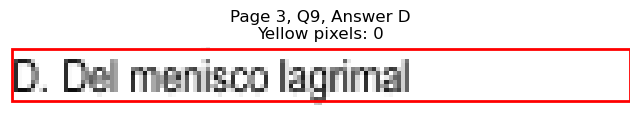


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)
Page 3, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=307.0, y1=708.0
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 1141
Page 3, Q10, A: Yellow percentage: 0.0%


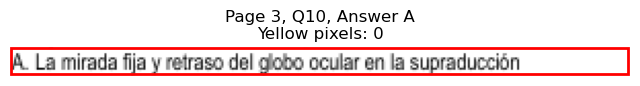

Page 3, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=396.8, y1=720.6
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 1687
Page 3, Q10, B: Yellow percentage: 0.0%


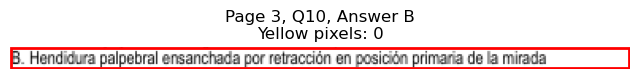

Page 3, Q10 - C: Detected box: x0=56.6, y0=720.6, x1=199.6, y1=733.2
Page 3, Q10, C: Yellow pixels: 194
Page 3, Q10, C: Total non-white pixels: 867
Page 3, Q10, C: Yellow percentage: 22.4%


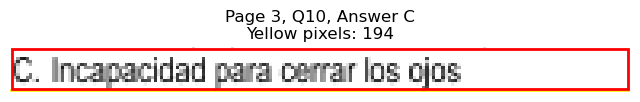

Page 3, Q10 - D: Detected box: x0=56.6, y0=733.2, x1=329.2, y1=745.8
Page 3, Q10, D: Yellow pixels: 3149
Page 3, Q10, D: Total non-white pixels: 4212
Page 3, Q10, D: Yellow percentage: 74.8%


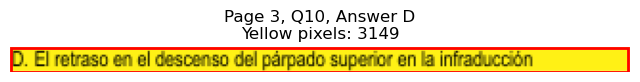


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)

Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=121.5, y1=102.1
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 330
Page 4, Q1, A: Yellow percentage: 0.0%


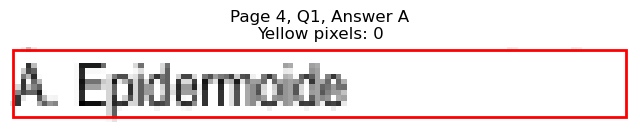

Page 4, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=154.1, y1=114.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 489
Page 4, Q1, B: Yellow percentage: 0.0%


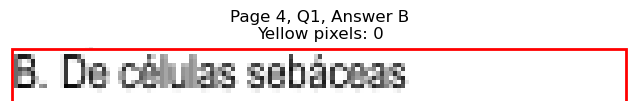

Page 4, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=377.2, y1=102.1
Page 4, Q1, C: Yellow pixels: 1255
Page 4, Q1, C: Total non-white pixels: 1582
Page 4, Q1, C: Yellow percentage: 79.3%


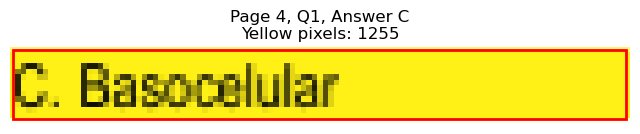

Page 4, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=414.3, y1=114.7
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 641
Page 4, Q1, D: Yellow percentage: 0.0%


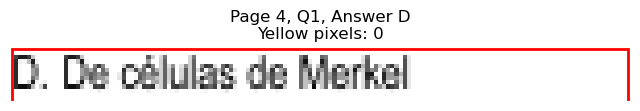


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=137.5, y1=152.6
Page 4, Q2, A: Yellow pixels: 132
Page 4, Q2, A: Total non-white pixels: 532
Page 4, Q2, A: Yellow percentage: 24.8%


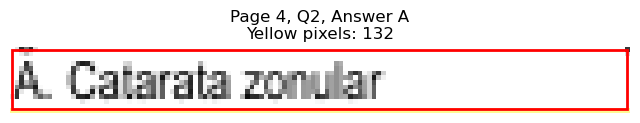

Page 4, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=161.1, y1=165.2
Page 4, Q2, B: Yellow pixels: 1639
Page 4, Q2, B: Total non-white pixels: 2184
Page 4, Q2, B: Yellow percentage: 75.0%


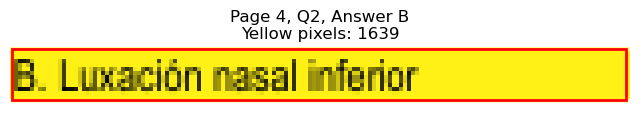

Page 4, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=401.2, y1=152.6
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 410
Page 4, Q2, C: Yellow percentage: 0.0%


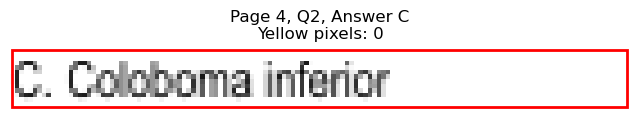

Page 4, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=406.7, y1=165.2
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 428
Page 4, Q2, D: Yellow percentage: 0.0%


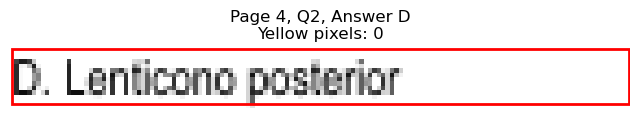


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=190.3, x1=112.0, y1=203.0
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 259
Page 4, Q3, A: Yellow percentage: 0.0%


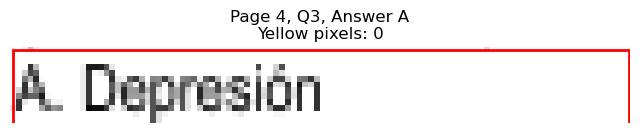

Page 4, Q3 - B: Detected box: x0=56.6, y0=202.9, x1=118.0, y1=215.6
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 284
Page 4, Q3, B: Yellow percentage: 0.0%


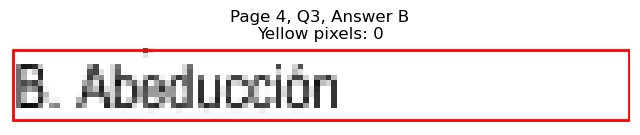

Page 4, Q3 - C: Detected box: x0=315.4, y0=190.3, x1=364.6, y1=203.0
Page 4, Q3, C: Yellow pixels: 1118
Page 4, Q3, C: Total non-white pixels: 1300
Page 4, Q3, C: Yellow percentage: 86.0%


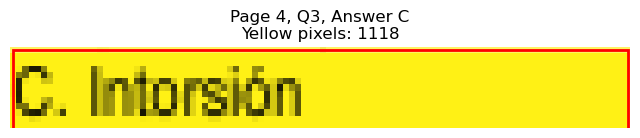

Page 4, Q3 - D: Detected box: x0=315.4, y0=202.9, x1=367.6, y1=215.6
Page 4, Q3, D: Yellow pixels: 103
Page 4, Q3, D: Total non-white pixels: 345
Page 4, Q3, D: Yellow percentage: 29.9%


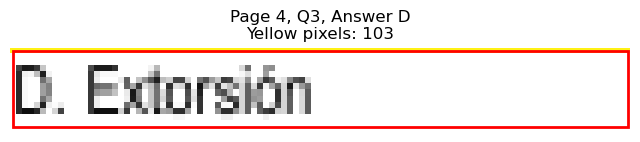


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=240.8, x1=377.7, y1=253.5
Page 4, Q4, A: Yellow pixels: 372
Page 4, Q4, A: Total non-white pixels: 1937
Page 4, Q4, A: Yellow percentage: 19.2%


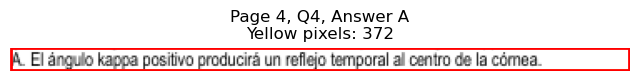

Page 4, Q4 - B: Detected box: x0=56.6, y0=253.4, x1=339.7, y1=266.1
Page 4, Q4, B: Yellow pixels: 3297
Page 4, Q4, B: Total non-white pixels: 4676
Page 4, Q4, B: Yellow percentage: 70.5%


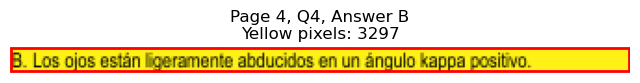

Page 4, Q4 - C: Detected box: x0=56.6, y0=266.0, x1=316.6, y1=278.7
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 1604
Page 4, Q4, C: Yellow percentage: 0.0%


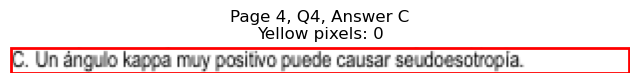

Page 4, Q4 - D: Detected box: x0=56.6, y0=278.8, x1=292.0, y1=291.4
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 1157
Page 4, Q4, D: Yellow percentage: 0.0%


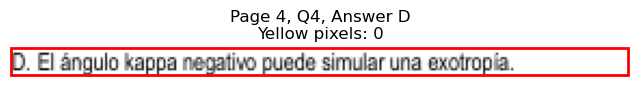


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=329.2, x1=117.5, y1=341.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 281
Page 4, Q5, A: Yellow percentage: 0.0%


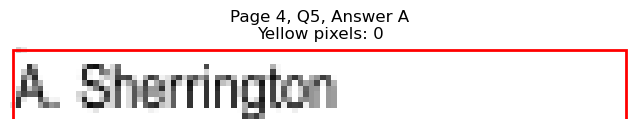

Page 4, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=111.4, y1=354.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 272
Page 4, Q5, B: Yellow percentage: 0.0%


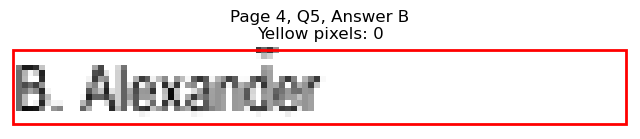

Page 4, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=356.6, y1=341.8
Page 4, Q5, C: Yellow pixels: 1035
Page 4, Q5, C: Total non-white pixels: 1196
Page 4, Q5, C: Yellow percentage: 86.5%


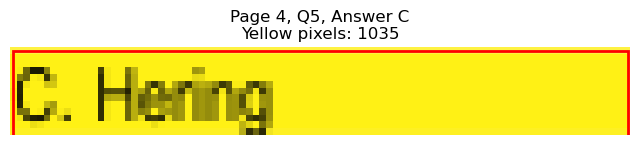

Page 4, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=362.1, y1=354.6
Page 4, Q5, D: Yellow pixels: 94
Page 4, Q5, D: Total non-white pixels: 297
Page 4, Q5, D: Yellow percentage: 31.6%


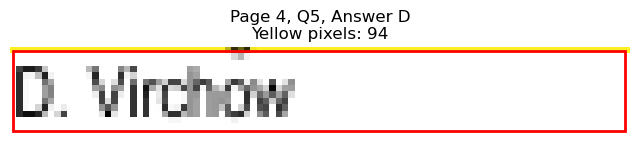


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=379.7, x1=150.0, y1=392.4
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 447
Page 4, Q6, A: Yellow percentage: 0.0%


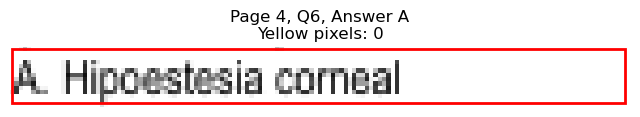

Page 4, Q6 - B: Detected box: x0=56.6, y0=392.3, x1=157.6, y1=405.0
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 475
Page 4, Q6, B: Yellow percentage: 0.0%


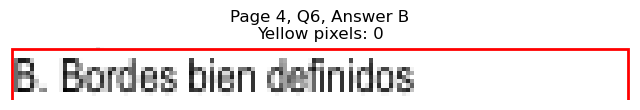

Page 4, Q6 - C: Detected box: x0=315.4, y0=379.7, x1=397.3, y1=392.4
Page 4, Q6, C: Yellow pixels: 1286
Page 4, Q6, C: Total non-white pixels: 1862
Page 4, Q6, C: Yellow percentage: 69.1%


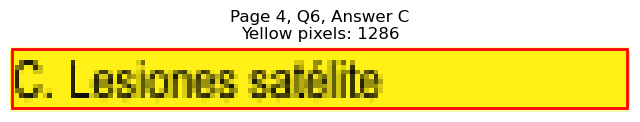

Page 4, Q6 - D: Detected box: x0=315.4, y0=392.3, x1=379.7, y1=405.0
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 441
Page 4, Q6, D: Yellow percentage: 0.0%


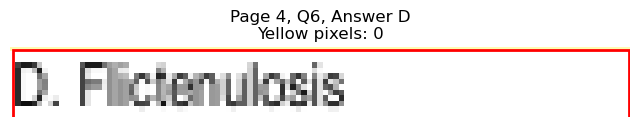


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=430.2, x1=109.0, y1=442.9
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 237
Page 4, Q7, A: Yellow percentage: 0.0%


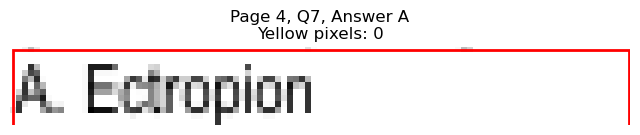

Page 4, Q7 - B: Detected box: x0=56.6, y0=442.8, x1=109.5, y1=455.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 254
Page 4, Q7, B: Yellow percentage: 0.0%


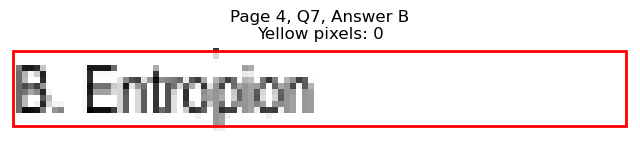

Page 4, Q7 - C: Detected box: x0=315.4, y0=430.2, x1=379.3, y1=442.9
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 397
Page 4, Q7, C: Yellow percentage: 0.0%


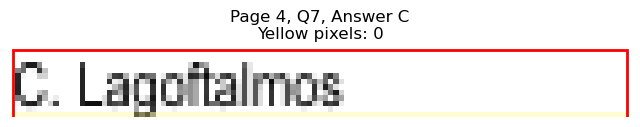

Page 4, Q7 - D: Detected box: x0=315.4, y0=442.8, x1=354.7, y1=455.5
Page 4, Q7, D: Yellow pixels: 1044
Page 4, Q7, D: Total non-white pixels: 1260
Page 4, Q7, D: Yellow percentage: 82.9%


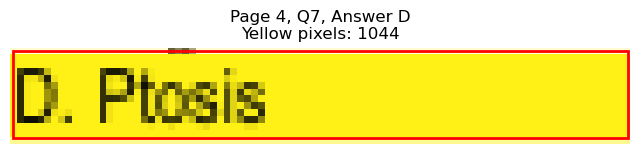


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=480.8, x1=123.5, y1=493.4
Page 4, Q8, A: Yellow pixels: 118
Page 4, Q8, A: Total non-white pixels: 433
Page 4, Q8, A: Yellow percentage: 27.3%


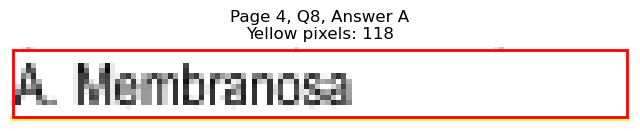

Page 4, Q8 - B: Detected box: x0=56.6, y0=493.4, x1=132.5, y1=506.0
Page 4, Q8, B: Yellow pixels: 1371
Page 4, Q8, B: Total non-white pixels: 1651
Page 4, Q8, B: Yellow percentage: 83.0%


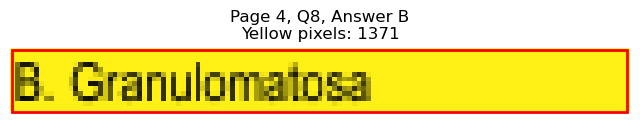

Page 4, Q8 - C: Detected box: x0=315.4, y0=480.8, x1=390.3, y1=493.4
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 372
Page 4, Q8, C: Yellow percentage: 0.0%


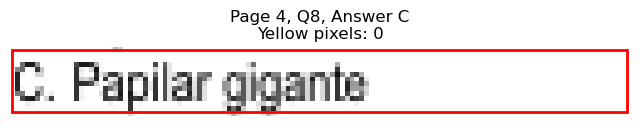

Page 4, Q8 - D: Detected box: x0=315.4, y0=493.4, x1=359.7, y1=506.0
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 189
Page 4, Q8, D: Yellow percentage: 0.0%


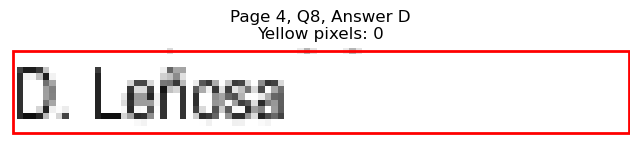


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=556.5, x1=171.1, y1=569.1
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 567
Page 4, Q9, A: Yellow percentage: 0.0%


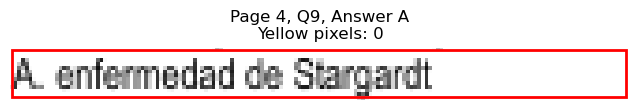

Page 4, Q9 - B: Detected box: x0=56.6, y0=569.1, x1=213.8, y1=581.7
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 772
Page 4, Q9, B: Yellow percentage: 0.0%


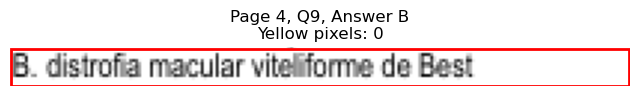

Page 4, Q9 - C: Detected box: x0=315.4, y0=556.5, x1=400.7, y1=569.1
Page 4, Q9, C: Yellow pixels: 136
Page 4, Q9, C: Total non-white pixels: 519
Page 4, Q9, C: Yellow percentage: 26.2%


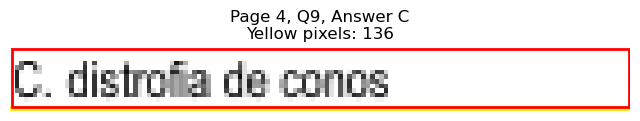

Page 4, Q9 - D: Detected box: x0=315.4, y0=569.1, x1=413.3, y1=581.7
Page 4, Q9, D: Yellow pixels: 1575
Page 4, Q9, D: Total non-white pixels: 1937
Page 4, Q9, D: Yellow percentage: 81.3%


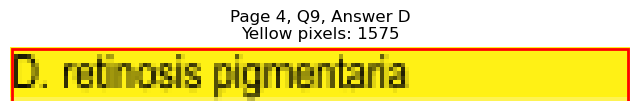


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=632.2, x1=314.6, y1=644.9
Page 4, Q10, A: Yellow pixels: 2968
Page 4, Q10, A: Total non-white pixels: 4017
Page 4, Q10, A: Yellow percentage: 73.9%


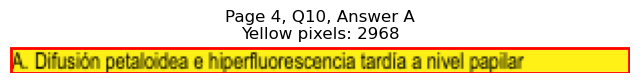

Page 4, Q10 - B: Detected box: x0=56.6, y0=644.8, x1=384.3, y1=657.5
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 1581
Page 4, Q10, B: Yellow percentage: 0.0%


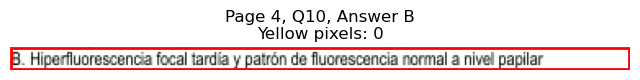

Page 4, Q10 - C: Detected box: x0=56.6, y0=657.4, x1=401.8, y1=670.1
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 1697
Page 4, Q10, C: Yellow percentage: 0.0%


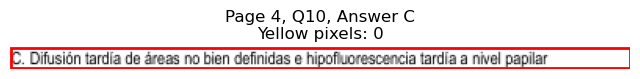

Page 4, Q10 - D: Detected box: x0=56.6, y0=670.0, x1=336.1, y1=682.7
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 1345
Page 4, Q10, D: Yellow percentage: 0.0%


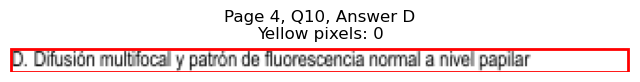


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)
Page 4, Q11 - A: Detected box: x0=56.6, y0=708.0, x1=95.4, y1=720.6
Page 4, Q11, A: Yellow pixels: 1058
Page 4, Q11, A: Total non-white pixels: 1260
Page 4, Q11, A: Yellow percentage: 84.0%


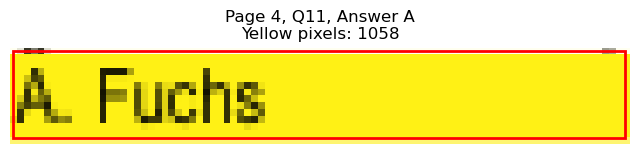

Page 4, Q11 - B: Detected box: x0=56.6, y0=720.6, x1=105.4, y1=733.2
Page 4, Q11, B: Yellow pixels: 100
Page 4, Q11, B: Total non-white pixels: 319
Page 4, Q11, B: Yellow percentage: 31.3%


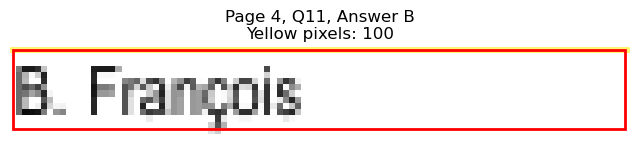

Page 4, Q11 - C: Detected box: x0=315.4, y0=708.0, x1=368.2, y1=720.6
Page 4, Q11, C: Yellow pixels: 0
Page 4, Q11, C: Total non-white pixels: 247
Page 4, Q11, C: Yellow percentage: 0.0%


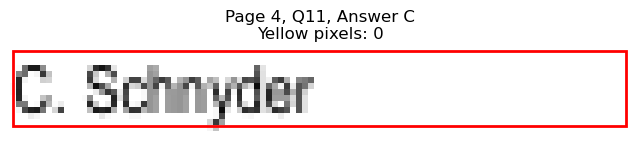

Page 4, Q11 - D: Detected box: x0=315.4, y0=720.6, x1=354.1, y1=733.2
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 193
Page 4, Q11, D: Yellow percentage: 0.0%


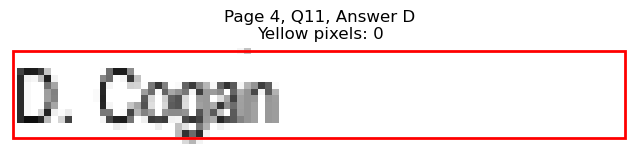


Page 4, Q11 - Selected Answer: A (based on yellow pixel count)

Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=89.4, y1=114.7
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 141
Page 5, Q1, A: Yellow percentage: 0.0%


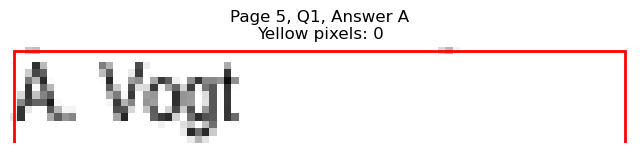

Page 5, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=100.9, y1=127.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 225
Page 5, Q1, B: Yellow percentage: 0.0%


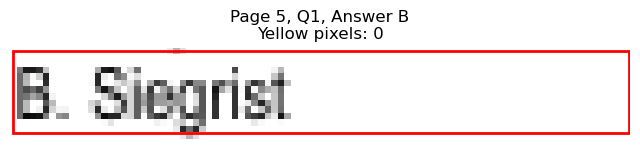

Page 5, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=351.7, y1=114.7
Page 5, Q1, C: Yellow pixels: 999
Page 5, Q1, C: Total non-white pixels: 1131
Page 5, Q1, C: Yellow percentage: 88.3%


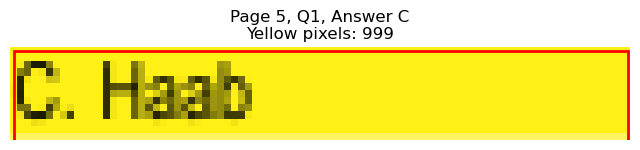

Page 5, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=351.2, y1=127.3
Page 5, Q1, D: Yellow pixels: 87
Page 5, Q1, D: Total non-white pixels: 224
Page 5, Q1, D: Yellow percentage: 38.8%


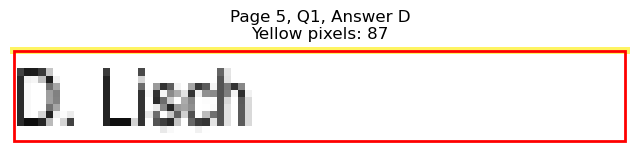


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=101.4, y1=165.2
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 208
Page 5, Q2, A: Yellow percentage: 0.0%


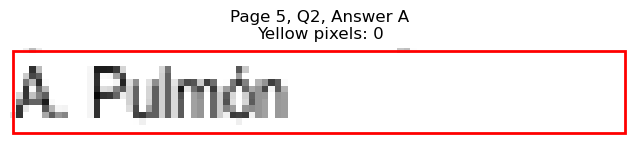

Page 5, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=99.9, y1=177.8
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 219
Page 5, Q2, B: Yellow percentage: 0.0%


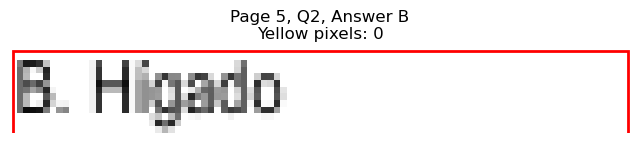

Page 5, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=345.1, y1=165.2
Page 5, Q2, C: Yellow pixels: 81
Page 5, Q2, C: Total non-white pixels: 194
Page 5, Q2, C: Yellow percentage: 41.8%


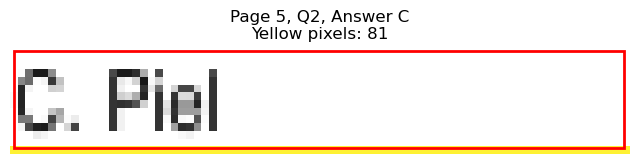

Page 5, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=355.1, y1=177.8
Page 5, Q2, D: Yellow pixels: 1036
Page 5, Q2, D: Total non-white pixels: 1183
Page 5, Q2, D: Yellow percentage: 87.6%


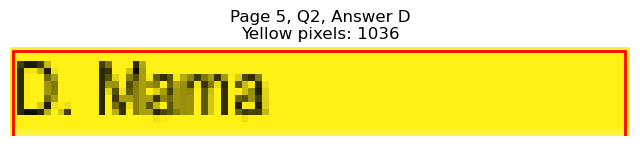


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=202.9, x1=149.5, y1=215.6
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 466
Page 5, Q3, A: Yellow percentage: 0.0%


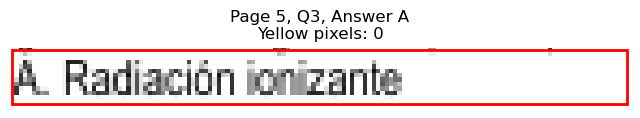

Page 5, Q3 - B: Detected box: x0=56.6, y0=215.6, x1=124.9, y1=228.3
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 327
Page 5, Q3, B: Yellow percentage: 0.0%


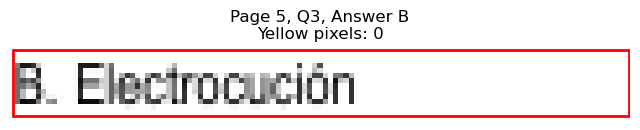

Page 5, Q3 - C: Detected box: x0=315.4, y0=202.9, x1=370.6, y1=215.6
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 252
Page 5, Q3, C: Yellow percentage: 0.0%


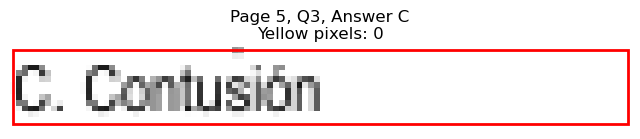

Page 5, Q3 - D: Detected box: x0=315.4, y0=215.6, x1=408.3, y1=228.3
Page 5, Q3, D: Yellow pixels: 1377
Page 5, Q3, D: Total non-white pixels: 2016
Page 5, Q3, D: Yellow percentage: 68.3%


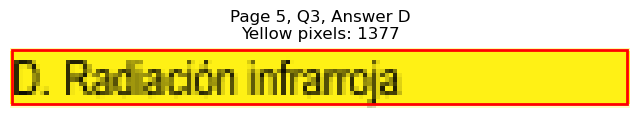


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=115.9, y1=278.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 278
Page 5, Q4, A: Yellow percentage: 0.0%


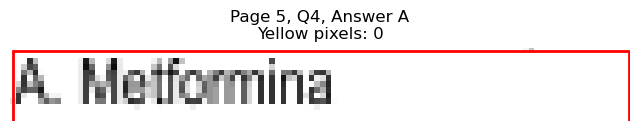

Page 5, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=103.5, y1=291.4
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 229
Page 5, Q4, B: Yellow percentage: 0.0%


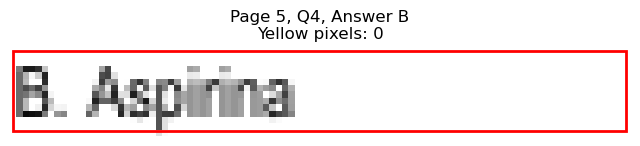

Page 5, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=389.2, y1=278.7
Page 5, Q4, C: Yellow pixels: 1355
Page 5, Q4, C: Total non-white pixels: 1625
Page 5, Q4, C: Yellow percentage: 83.4%


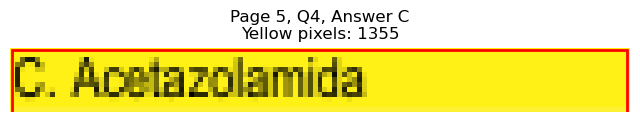

Page 5, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=375.7, y1=291.4
Page 5, Q4, D: Yellow pixels: 111
Page 5, Q4, D: Total non-white pixels: 425
Page 5, Q4, D: Yellow percentage: 26.1%


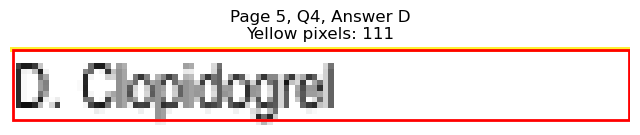


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=316.6, x1=152.1, y1=329.2
Page 5, Q5, A: Yellow pixels: 1401
Page 5, Q5, A: Total non-white pixels: 2058
Page 5, Q5, A: Yellow percentage: 68.1%


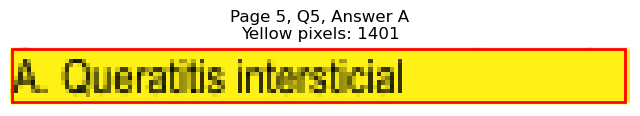

Page 5, Q5 - B: Detected box: x0=56.6, y0=329.2, x1=168.6, y1=341.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 695
Page 5, Q5, B: Yellow percentage: 0.0%


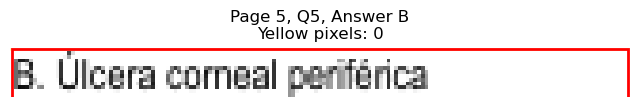

Page 5, Q5 - C: Detected box: x0=315.4, y0=316.6, x1=391.7, y1=329.2
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 365
Page 5, Q5, C: Yellow percentage: 0.0%


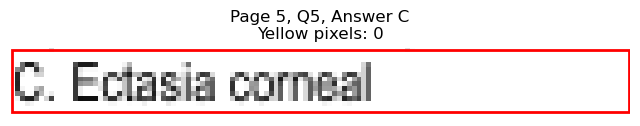

Page 5, Q5 - D: Detected box: x0=315.4, y0=329.2, x1=399.8, y1=341.8
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 413
Page 5, Q5, D: Yellow percentage: 0.0%


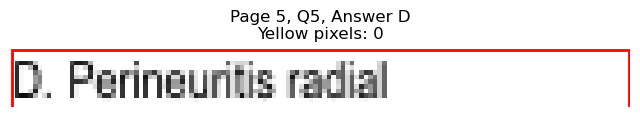


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=367.1, x1=311.6, y1=379.8
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 1195
Page 5, Q6, A: Yellow percentage: 0.0%


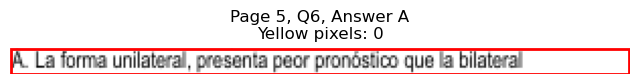

Page 5, Q6 - B: Detected box: x0=56.6, y0=379.7, x1=367.7, y1=392.4
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 1502
Page 5, Q6, B: Yellow percentage: 0.0%


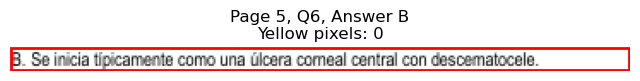

Page 5, Q6 - C: Detected box: x0=56.6, y0=392.3, x1=380.3, y1=405.0
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 1871
Page 5, Q6, C: Yellow percentage: 0.0%


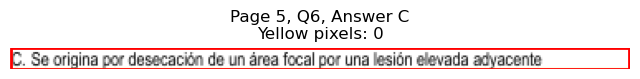

Page 5, Q6 - D: Detected box: x0=56.6, y0=404.9, x1=339.8, y1=417.6
Page 5, Q6, D: Yellow pixels: 3295
Page 5, Q6, D: Total non-white pixels: 4676
Page 5, Q6, D: Yellow percentage: 70.5%


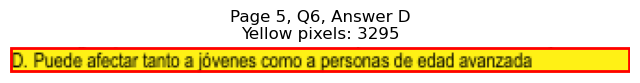


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=442.8, x1=110.9, y1=455.5
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 290
Page 5, Q7, A: Yellow percentage: 0.0%


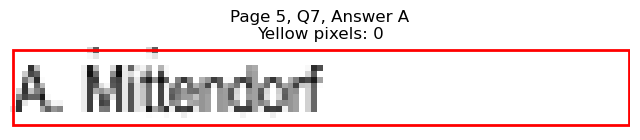

Page 5, Q7 - B: Detected box: x0=56.6, y0=455.5, x1=117.5, y1=468.1
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 308
Page 5, Q7, B: Yellow percentage: 0.0%


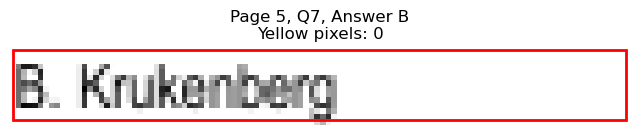

Page 5, Q7 - C: Detected box: x0=315.4, y0=442.8, x1=362.7, y1=455.5
Page 5, Q7, C: Yellow pixels: 98
Page 5, Q7, C: Total non-white pixels: 307
Page 5, Q7, C: Yellow percentage: 31.9%


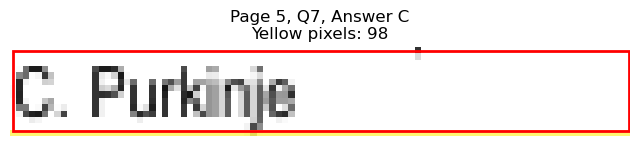

Page 5, Q7 - D: Detected box: x0=315.4, y0=455.5, x1=378.7, y1=468.1
Page 5, Q7, D: Yellow pixels: 1235
Page 5, Q7, D: Total non-white pixels: 1596
Page 5, Q7, D: Yellow percentage: 77.4%


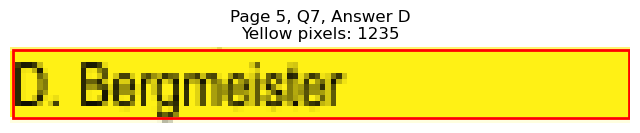


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=493.4, x1=376.7, y1=506.0
Page 5, Q8, A: Yellow pixels: 371
Page 5, Q8, A: Total non-white pixels: 2331
Page 5, Q8, A: Yellow percentage: 15.9%


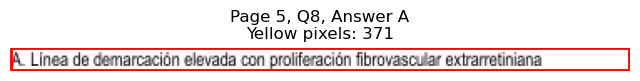

Page 5, Q8 - B: Detected box: x0=56.6, y0=506.0, x1=391.3, y1=518.6
Page 5, Q8, B: Yellow pixels: 3807
Page 5, Q8, B: Total non-white pixels: 5404
Page 5, Q8, B: Yellow percentage: 70.4%


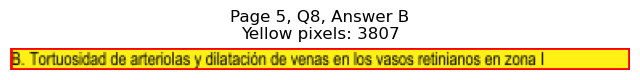

Page 5, Q8 - C: Detected box: x0=56.6, y0=518.6, x1=384.8, y1=531.2
Page 5, Q8, C: Yellow pixels: 378
Page 5, Q8, C: Total non-white pixels: 1983
Page 5, Q8, C: Yellow percentage: 19.1%


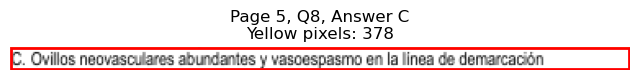

Page 5, Q8 - D: Detected box: x0=56.6, y0=531.2, x1=383.8, y1=543.8
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 1597
Page 5, Q8, D: Yellow percentage: 0.0%


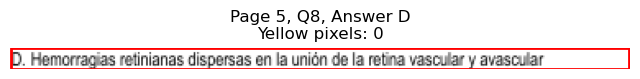


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=569.1, x1=393.3, y1=581.7
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 1676
Page 5, Q9, A: Yellow percentage: 0.0%


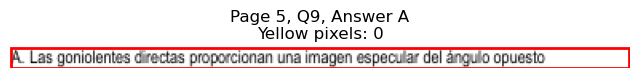

Page 5, Q9 - B: Detected box: x0=56.6, y0=581.7, x1=366.3, y1=594.3
Page 5, Q9, B: Yellow pixels: 361
Page 5, Q9, B: Total non-white pixels: 1924
Page 5, Q9, B: Yellow percentage: 18.8%


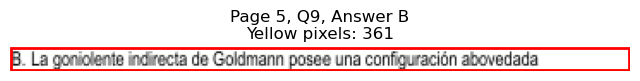

Page 5, Q9 - C: Detected box: x0=56.6, y0=594.3, x1=410.8, y1=606.9
Page 5, Q9, C: Yellow pixels: 3869
Page 5, Q9, C: Total non-white pixels: 5265
Page 5, Q9, C: Yellow percentage: 73.5%


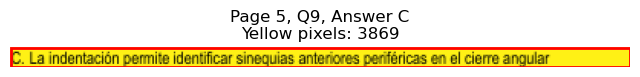

Page 5, Q9 - D: Detected box: x0=56.6, y0=606.9, x1=315.5, y1=619.5
Page 5, Q9, D: Yellow pixels: 304
Page 5, Q9, D: Total non-white pixels: 1567
Page 5, Q9, D: Yellow percentage: 19.4%


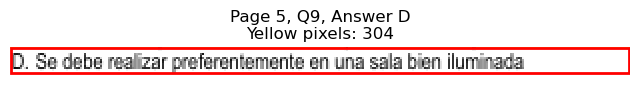


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=657.4, x1=125.4, y1=670.1
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 348
Page 5, Q10, A: Yellow percentage: 0.0%


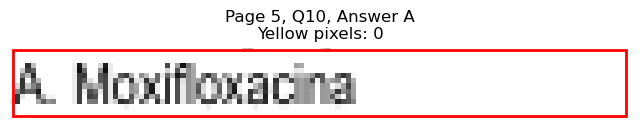

Page 5, Q10 - B: Detected box: x0=56.6, y0=670.0, x1=104.4, y1=682.7
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 220
Page 5, Q10, B: Yellow percentage: 0.0%


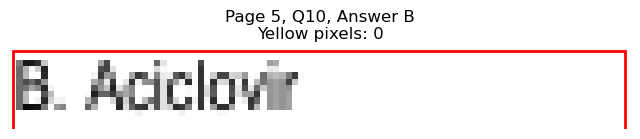

Page 5, Q10 - C: Detected box: x0=315.4, y0=657.4, x1=376.1, y1=670.1
Page 5, Q10, C: Yellow pixels: 112
Page 5, Q10, C: Total non-white pixels: 397
Page 5, Q10, C: Yellow percentage: 28.2%


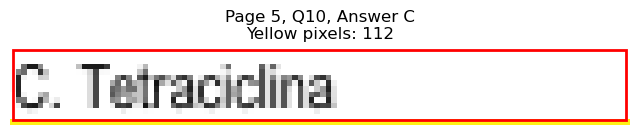

Page 5, Q10 - D: Detected box: x0=315.4, y0=670.0, x1=382.7, y1=682.7
Page 5, Q10, D: Yellow pixels: 1297
Page 5, Q10, D: Total non-white pixels: 1534
Page 5, Q10, D: Yellow percentage: 84.6%


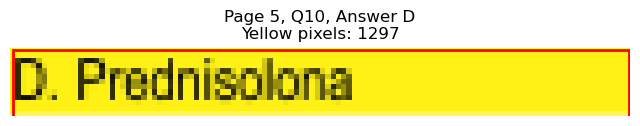


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)
Page 5, Q11 - A: Detected box: x0=56.6, y0=708.0, x1=140.1, y1=720.6
Page 5, Q11, A: Yellow pixels: 135
Page 5, Q11, A: Total non-white pixels: 587
Page 5, Q11, A: Yellow percentage: 23.0%


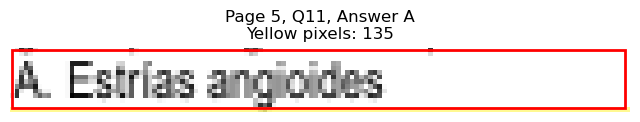

Page 5, Q11 - B: Detected box: x0=56.6, y0=720.6, x1=203.7, y1=733.2
Page 5, Q11, B: Yellow pixels: 2016
Page 5, Q11, B: Total non-white pixels: 2772
Page 5, Q11, B: Yellow percentage: 72.7%


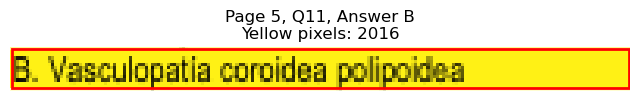

Page 5, Q11 - C: Detected box: x0=315.4, y0=708.0, x1=403.7, y1=720.6
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 403
Page 5, Q11, C: Yellow percentage: 0.0%


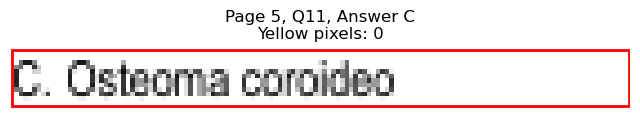

Page 5, Q11 - D: Detected box: x0=315.4, y0=720.6, x1=446.4, y1=733.2
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 641
Page 5, Q11, D: Yellow percentage: 0.0%


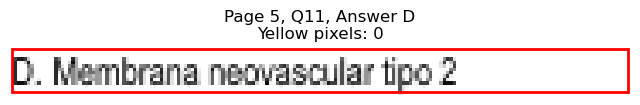


Page 5, Q11 - Selected Answer: B (based on yellow pixel count)

Page 6: Found 12 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=246.4, y1=102.1
Page 6, Q1, A: Yellow pixels: 2404
Page 6, Q1, A: Total non-white pixels: 3374
Page 6, Q1, A: Yellow percentage: 71.3%


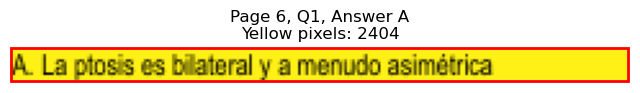

Page 6, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=283.5, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 1381
Page 6, Q1, B: Yellow percentage: 0.0%


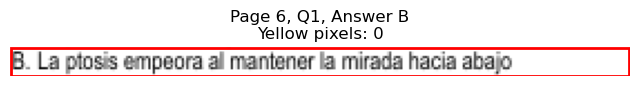

Page 6, Q1 - C: Detected box: x0=56.6, y0=114.6, x1=257.4, y1=127.3
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 934
Page 6, Q1, C: Yellow percentage: 0.0%


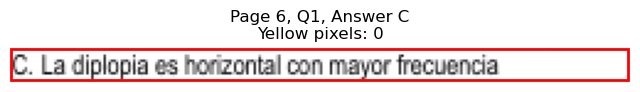

Page 6, Q1 - D: Detected box: x0=56.6, y0=127.2, x1=256.4, y1=139.9
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 928
Page 6, Q1, D: Yellow percentage: 0.0%


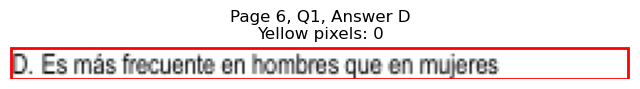


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=235.4, y1=177.8
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 887
Page 6, Q2, A: Yellow percentage: 0.0%


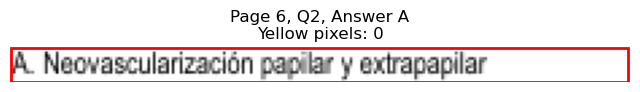

Page 6, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=216.8, y1=190.4
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 769
Page 6, Q2, B: Yellow percentage: 0.0%


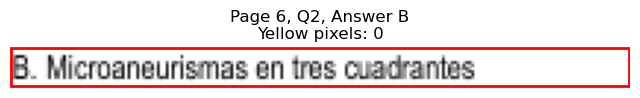

Page 6, Q2 - C: Detected box: x0=56.6, y0=190.3, x1=253.4, y1=203.0
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 1151
Page 6, Q2, C: Yellow percentage: 0.0%


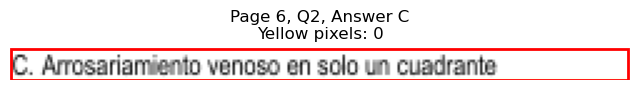

Page 6, Q2 - D: Detected box: x0=56.6, y0=202.9, x1=291.5, y1=215.6
Page 6, Q2, D: Yellow pixels: 2839
Page 6, Q2, D: Total non-white pixels: 4004
Page 6, Q2, D: Yellow percentage: 70.9%


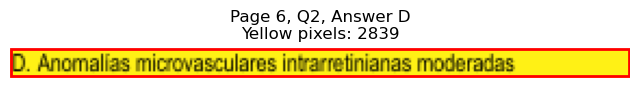


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=75.9, y1=266.1
Page 6, Q3, A: Yellow pixels: 861
Page 6, Q3, A: Total non-white pixels: 980
Page 6, Q3, A: Yellow percentage: 87.9%


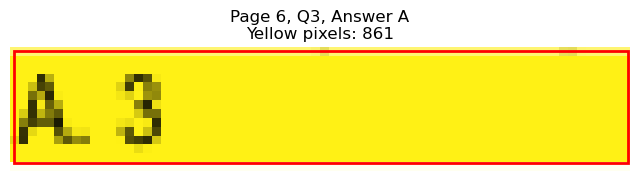

Page 6, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=75.9, y1=278.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 139
Page 6, Q3, B: Yellow percentage: 0.0%


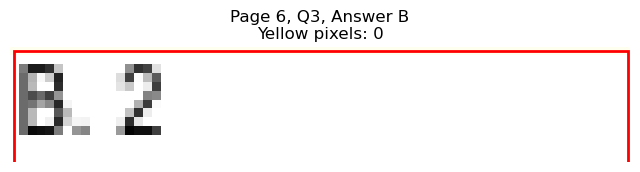

Page 6, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=335.1, y1=266.1
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 65
Page 6, Q3, C: Yellow percentage: 0.0%


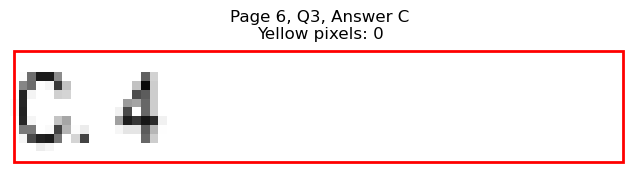

Page 6, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=335.1, y1=278.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 53
Page 6, Q3, D: Yellow percentage: 0.0%


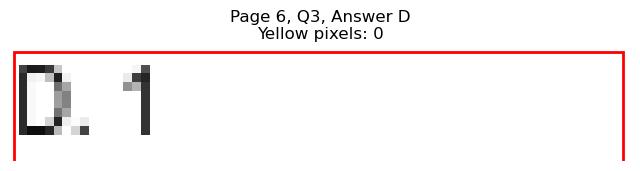


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=167.1, y1=316.6
Page 6, Q4, A: Yellow pixels: 1685
Page 6, Q4, A: Total non-white pixels: 2117
Page 6, Q4, A: Yellow percentage: 79.6%


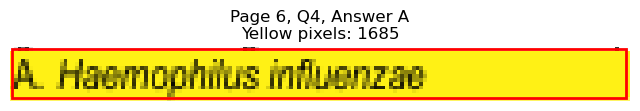

Page 6, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=171.1, y1=329.2
Page 6, Q4, B: Yellow pixels: 166
Page 6, Q4, B: Total non-white pixels: 725
Page 6, Q4, B: Yellow percentage: 22.9%


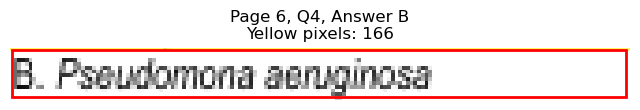

Page 6, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=423.3, y1=316.6
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 526
Page 6, Q4, C: Yellow percentage: 0.0%


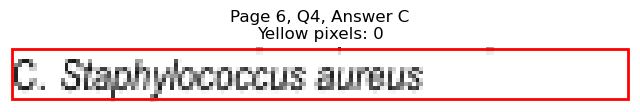

Page 6, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=428.8, y1=329.2
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 564
Page 6, Q4, D: Yellow percentage: 0.0%


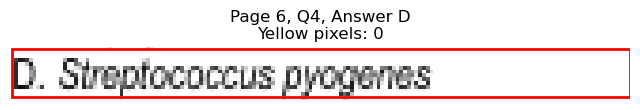


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=181.1, y1=379.8
Page 6, Q5, A: Yellow pixels: 1818
Page 6, Q5, A: Total non-white pixels: 2288
Page 6, Q5, A: Yellow percentage: 79.5%


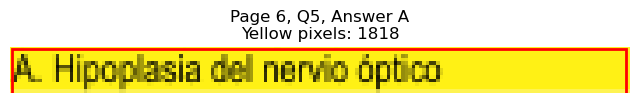

Page 6, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=180.1, y1=392.4
Page 6, Q5, B: Yellow pixels: 175
Page 6, Q5, B: Total non-white pixels: 760
Page 6, Q5, B: Yellow percentage: 23.0%


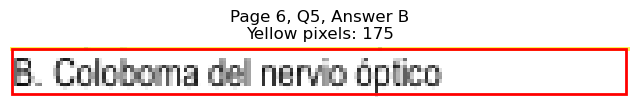

Page 6, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=437.8, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 571
Page 6, Q5, C: Yellow percentage: 0.0%


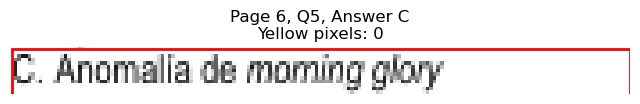

Page 6, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=422.3, y1=392.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 531
Page 6, Q5, D: Yellow percentage: 0.0%


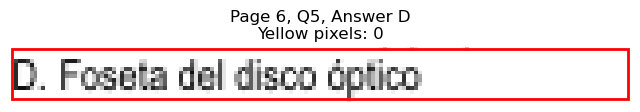


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=200.8, y1=430.3
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 685
Page 6, Q6, A: Yellow percentage: 0.0%


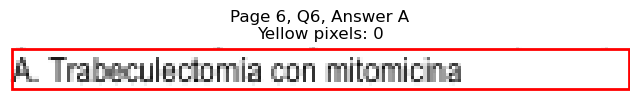

Page 6, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=205.2, y1=442.9
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 727
Page 6, Q6, B: Yellow percentage: 0.0%


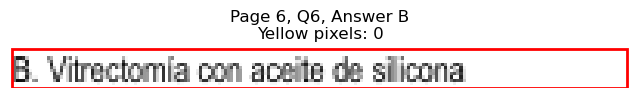

Page 6, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=476.5, y1=430.3
Page 6, Q6, C: Yellow pixels: 1925
Page 6, Q6, C: Total non-white pixels: 2968
Page 6, Q6, C: Yellow percentage: 64.9%


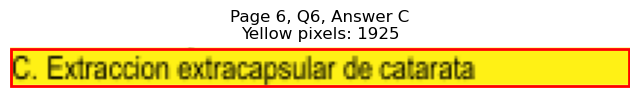

Page 6, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=415.3, y1=442.9
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 632
Page 6, Q6, D: Yellow percentage: 0.0%


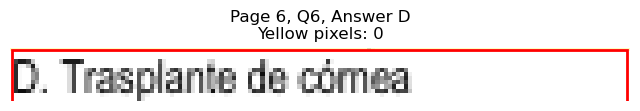


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=106.9, y1=480.7
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 240
Page 6, Q7, A: Yellow percentage: 0.0%


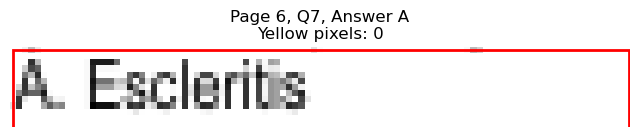

Page 6, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=112.0, y1=493.4
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 247
Page 6, Q7, B: Yellow percentage: 0.0%


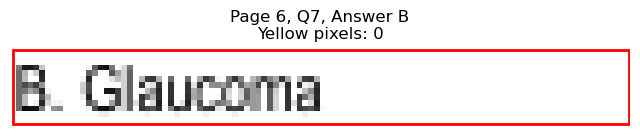

Page 6, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=378.7, y1=480.7
Page 6, Q7, C: Yellow pixels: 1246
Page 6, Q7, C: Total non-white pixels: 1482
Page 6, Q7, C: Yellow percentage: 84.1%


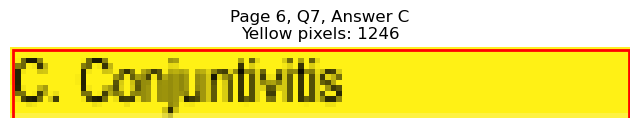

Page 6, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=361.1, y1=493.4
Page 6, Q7, D: Yellow pixels: 96
Page 6, Q7, D: Total non-white pixels: 319
Page 6, Q7, D: Yellow percentage: 30.1%


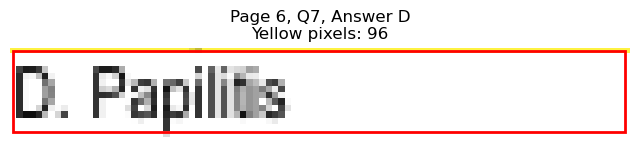


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=86.3, y1=543.8
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 188
Page 6, Q8, A: Yellow percentage: 0.0%


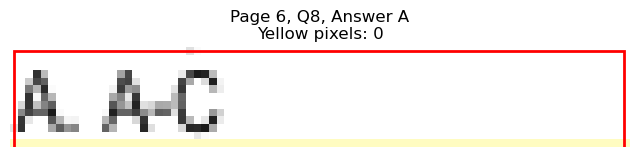

Page 6, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=86.3, y1=556.4
Page 6, Q8, B: Yellow pixels: 956
Page 6, Q8, B: Total non-white pixels: 1134
Page 6, Q8, B: Yellow percentage: 84.3%


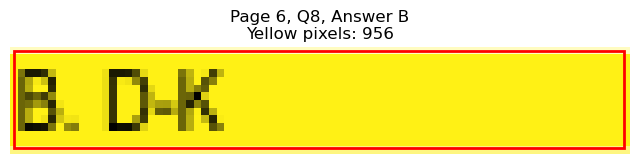

Page 6, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=345.5, y1=543.8
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 101
Page 6, Q8, C: Yellow percentage: 0.0%


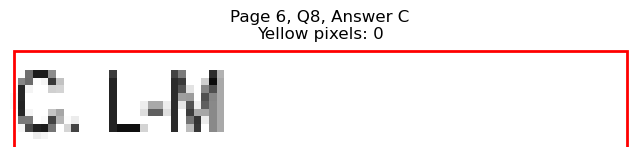

Page 6, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=346.1, y1=556.4
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 120
Page 6, Q8, D: Yellow percentage: 0.0%


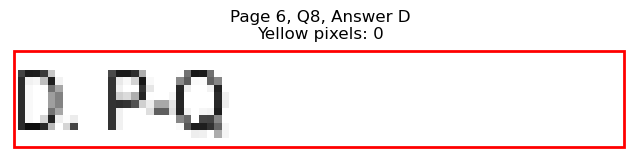


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=119.4, y1=594.3
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 314
Page 6, Q9, A: Yellow percentage: 0.0%


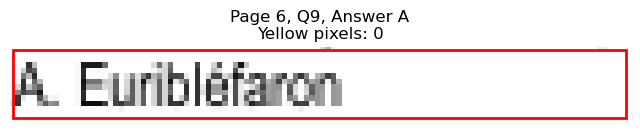

Page 6, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=133.5, y1=606.9
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 376
Page 6, Q9, B: Yellow percentage: 0.0%


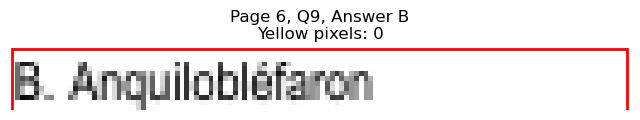

Page 6, Q9 - C: Detected box: x0=315.4, y0=581.7, x1=380.7, y1=594.3
Page 6, Q9, C: Yellow pixels: 1143
Page 6, Q9, C: Total non-white pixels: 1624
Page 6, Q9, C: Yellow percentage: 70.4%


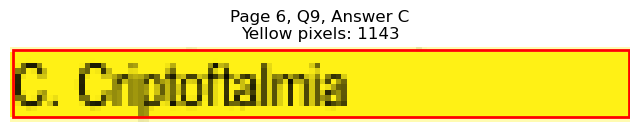

Page 6, Q9 - D: Detected box: x0=315.4, y0=594.3, x1=384.7, y1=606.9
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 471
Page 6, Q9, D: Yellow percentage: 0.0%


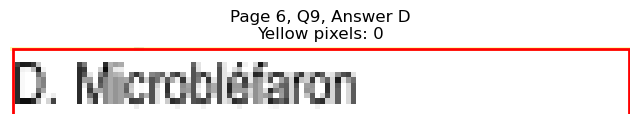


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=632.2, x1=183.6, y1=644.9
Page 6, Q10, A: Yellow pixels: 1798
Page 6, Q10, A: Total non-white pixels: 2314
Page 6, Q10, A: Yellow percentage: 77.7%


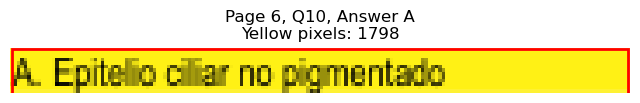

Page 6, Q10 - B: Detected box: x0=56.6, y0=644.8, x1=171.1, y1=657.5
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 603
Page 6, Q10, B: Yellow percentage: 0.0%


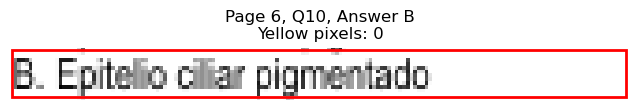

Page 6, Q10 - C: Detected box: x0=315.4, y0=632.2, x1=437.8, y1=644.9
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 609
Page 6, Q10, C: Yellow percentage: 0.0%


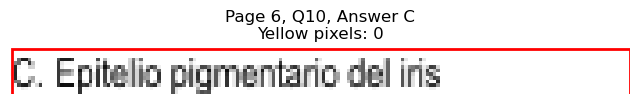

Page 6, Q10 - D: Detected box: x0=315.4, y0=644.8, x1=429.3, y1=657.5
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 558
Page 6, Q10, D: Yellow percentage: 0.0%


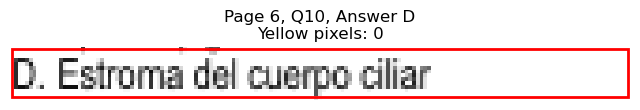


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)
Page 6, Q11 - A: Detected box: x0=56.6, y0=682.6, x1=184.1, y1=695.3
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 625
Page 6, Q11, A: Yellow percentage: 0.0%


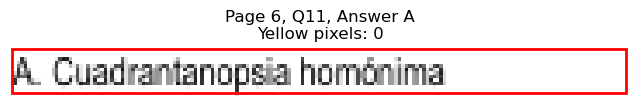

Page 6, Q11 - B: Detected box: x0=56.6, y0=695.4, x1=159.6, y1=708.0
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 500
Page 6, Q11, B: Yellow percentage: 0.0%


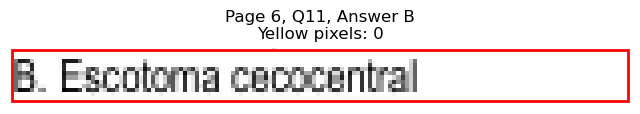

Page 6, Q11 - C: Detected box: x0=315.4, y0=682.6, x1=446.5, y1=695.3
Page 6, Q11, C: Yellow pixels: 0
Page 6, Q11, C: Total non-white pixels: 657
Page 6, Q11, C: Yellow percentage: 0.0%


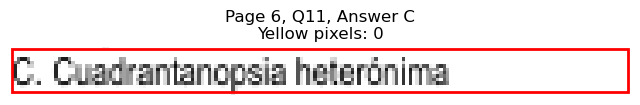

Page 6, Q11 - D: Detected box: x0=315.4, y0=695.4, x1=423.3, y1=708.0
Page 6, Q11, D: Yellow pixels: 1665
Page 6, Q11, D: Total non-white pixels: 2068
Page 6, Q11, D: Yellow percentage: 80.5%


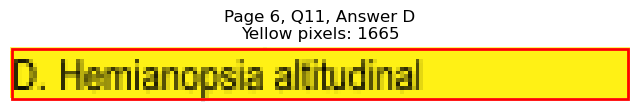


Page 6, Q11 - Selected Answer: D (based on yellow pixel count)
Page 6, Q12 - A: Detected box: x0=56.6, y0=745.8, x1=208.2, y1=758.4
Page 6, Q12, A: Yellow pixels: 0
Page 6, Q12, A: Total non-white pixels: 766
Page 6, Q12, A: Yellow percentage: 0.0%


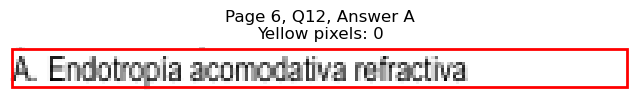

Page 6, Q12 - B: Detected box: x0=56.6, y0=758.5, x1=175.6, y1=771.1
Page 6, Q12, B: Yellow pixels: 0
Page 6, Q12, B: Total non-white pixels: 531
Page 6, Q12, B: Yellow percentage: 0.0%


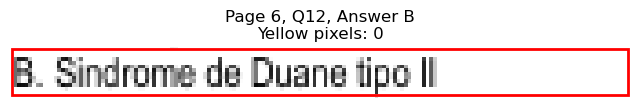

Page 6, Q12 - C: Detected box: x0=315.4, y0=745.8, x1=456.4, y1=758.4
Page 6, Q12, C: Yellow pixels: 1954
Page 6, Q12, C: Total non-white pixels: 2688
Page 6, Q12, C: Yellow percentage: 72.7%


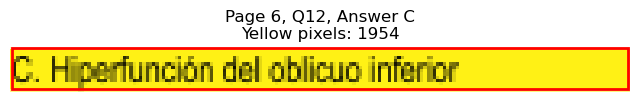

Page 6, Q12 - D: Detected box: x0=315.4, y0=758.5, x1=409.3, y1=771.1
Page 6, Q12, D: Yellow pixels: 145
Page 6, Q12, D: Total non-white pixels: 561
Page 6, Q12, D: Yellow percentage: 25.8%


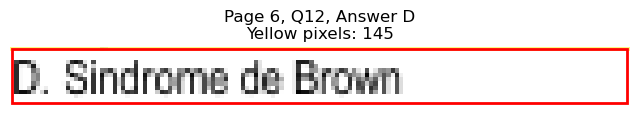


Page 6, Q12 - Selected Answer: C (based on yellow pixel count)

Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=138.0, y1=102.1
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 385
Page 7, Q1, A: Yellow percentage: 0.0%


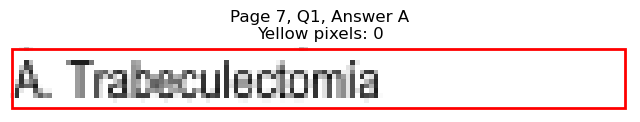

Page 7, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=155.1, y1=114.7
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 473
Page 7, Q1, B: Yellow percentage: 0.0%


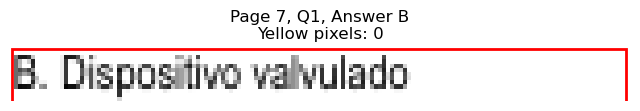

Page 7, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=396.3, y1=102.1
Page 7, Q1, C: Yellow pixels: 132
Page 7, Q1, C: Total non-white pixels: 526
Page 7, Q1, C: Yellow percentage: 25.1%


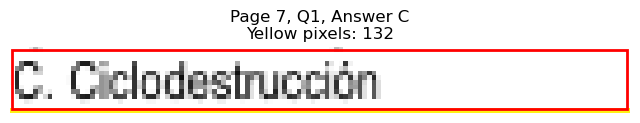

Page 7, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=418.9, y1=114.7
Page 7, Q1, D: Yellow pixels: 1616
Page 7, Q1, D: Total non-white pixels: 2002
Page 7, Q1, D: Yellow percentage: 80.7%


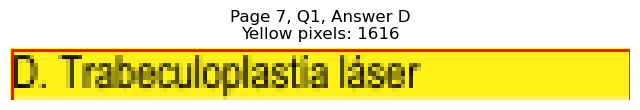


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=257.8, y1=152.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 1051
Page 7, Q2, A: Yellow percentage: 0.0%


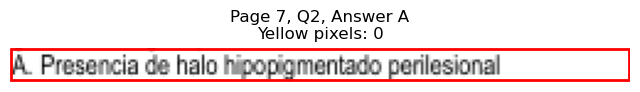

Page 7, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=248.8, y1=165.2
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 914
Page 7, Q2, B: Yellow percentage: 0.0%


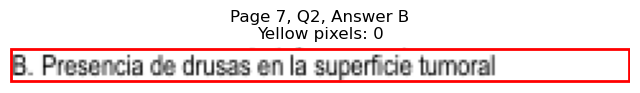

Page 7, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=443.9, y1=152.6
Page 7, Q2, C: Yellow pixels: 1848
Page 7, Q2, C: Total non-white pixels: 2506
Page 7, Q2, C: Yellow percentage: 73.7%


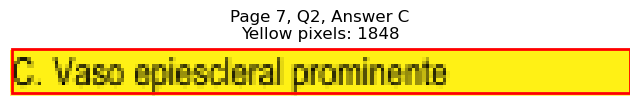

Page 7, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=468.5, y1=165.2
Page 7, Q2, D: Yellow pixels: 204
Page 7, Q2, D: Total non-white pixels: 956
Page 7, Q2, D: Yellow percentage: 21.3%


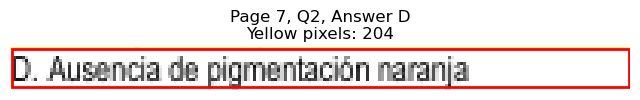


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=190.3, x1=317.2, y1=203.0
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 1575
Page 7, Q3, A: Yellow percentage: 0.0%


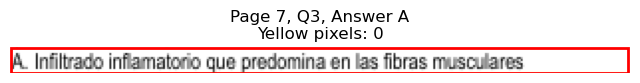

Page 7, Q3 - B: Detected box: x0=56.6, y0=202.9, x1=283.5, y1=215.6
Page 7, Q3, B: Yellow pixels: 2784
Page 7, Q3, B: Total non-white pixels: 3892
Page 7, Q3, B: Yellow percentage: 71.5%


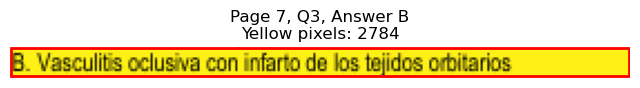

Page 7, Q3 - C: Detected box: x0=56.6, y0=215.6, x1=348.7, y1=228.3
Page 7, Q3, C: Yellow pixels: 342
Page 7, Q3, C: Total non-white pixels: 1781
Page 7, Q3, C: Yellow percentage: 19.2%


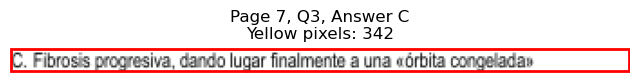

Page 7, Q3 - D: Detected box: x0=56.6, y0=228.2, x1=258.4, y1=240.9
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 983
Page 7, Q3, D: Yellow percentage: 0.0%


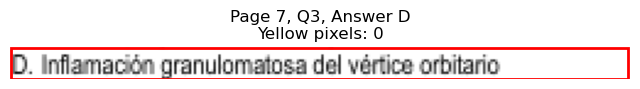


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=331.1, y1=278.7
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 1330
Page 7, Q4, A: Yellow percentage: 0.0%


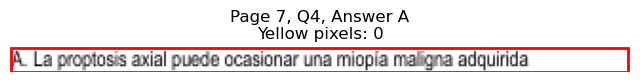

Page 7, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=398.3, y1=291.4
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 1721
Page 7, Q4, B: Yellow percentage: 0.0%


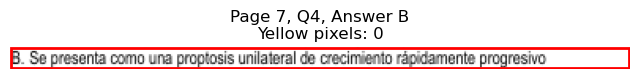

Page 7, Q4 - C: Detected box: x0=56.6, y0=291.4, x1=350.7, y1=304.0
Page 7, Q4, C: Yellow pixels: 345
Page 7, Q4, C: Total non-white pixels: 1700
Page 7, Q4, C: Yellow percentage: 20.3%


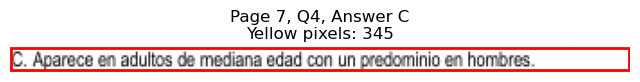

Page 7, Q4 - D: Detected box: x0=56.6, y0=304.0, x1=332.1, y1=316.6
Page 7, Q4, D: Yellow pixels: 3217
Page 7, Q4, D: Total non-white pixels: 4255
Page 7, Q4, D: Yellow percentage: 75.6%


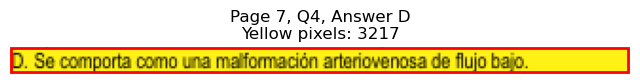


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=144.0, y1=354.6
Page 7, Q5, A: Yellow pixels: 139
Page 7, Q5, A: Total non-white pixels: 560
Page 7, Q5, A: Yellow percentage: 24.8%


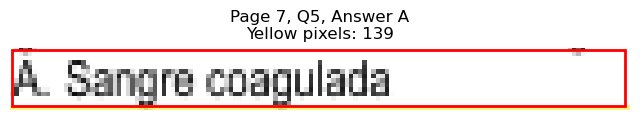

Page 7, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=141.5, y1=367.2
Page 7, Q5, B: Yellow pixels: 1445
Page 7, Q5, B: Total non-white pixels: 1904
Page 7, Q5, B: Yellow percentage: 75.9%


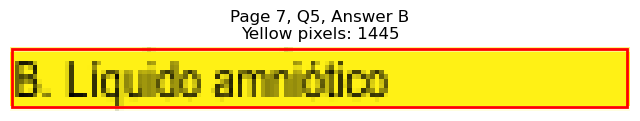

Page 7, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=398.2, y1=354.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 388
Page 7, Q5, C: Yellow percentage: 0.0%


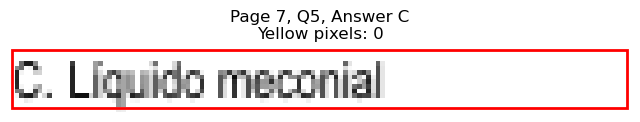

Page 7, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=372.2, y1=367.2
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 272
Page 7, Q5, D: Yellow percentage: 0.0%


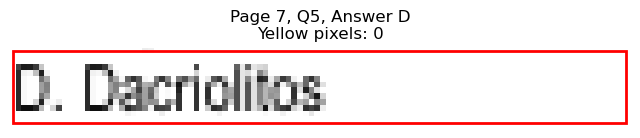


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=392.3, x1=103.5, y1=405.0
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 312
Page 7, Q6, A: Yellow percentage: 0.0%


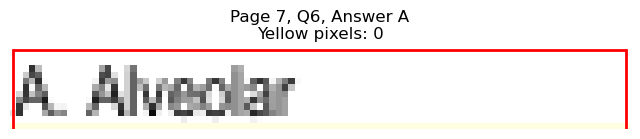

Page 7, Q6 - B: Detected box: x0=56.6, y0=404.9, x1=119.4, y1=417.6
Page 7, Q6, B: Yellow pixels: 1231
Page 7, Q6, B: Total non-white pixels: 1596
Page 7, Q6, B: Yellow percentage: 77.1%


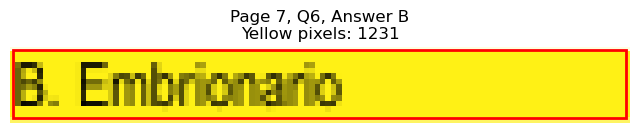

Page 7, Q6 - C: Detected box: x0=315.4, y0=392.3, x1=365.7, y1=405.0
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 249
Page 7, Q6, C: Yellow percentage: 0.0%


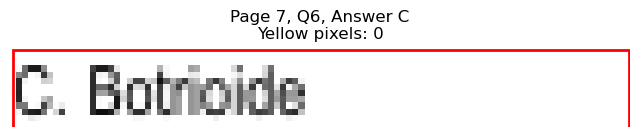

Page 7, Q6 - D: Detected box: x0=315.4, y0=404.9, x1=371.2, y1=417.6
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 245
Page 7, Q6, D: Yellow percentage: 0.0%


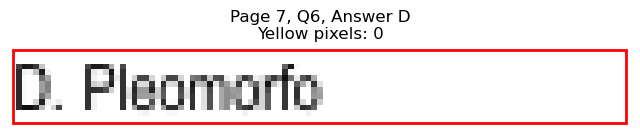


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=442.8, x1=264.9, y1=455.5
Page 7, Q7, A: Yellow pixels: 259
Page 7, Q7, A: Total non-white pixels: 1253
Page 7, Q7, A: Yellow percentage: 20.7%


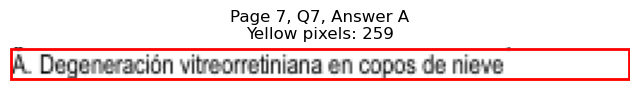

Page 7, Q7 - B: Detected box: x0=56.6, y0=455.5, x1=271.5, y1=468.1
Page 7, Q7, B: Yellow pixels: 2577
Page 7, Q7, B: Total non-white pixels: 3724
Page 7, Q7, B: Yellow percentage: 69.2%


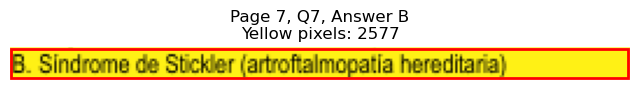

Page 7, Q7 - C: Detected box: x0=56.6, y0=468.1, x1=352.1, y1=480.7
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 1818
Page 7, Q7, C: Yellow percentage: 0.0%


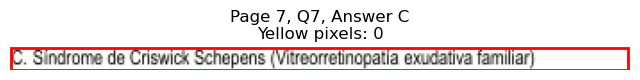

Page 7, Q7 - D: Detected box: x0=56.6, y0=480.8, x1=263.3, y1=493.4
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 1044
Page 7, Q7, D: Yellow percentage: 0.0%


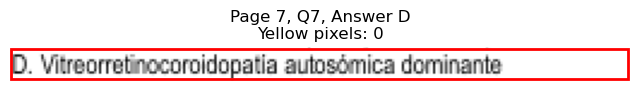


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=150.1, y1=543.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 472
Page 7, Q8, A: Yellow percentage: 0.0%


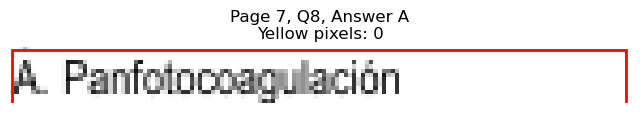

Page 7, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=116.4, y1=556.4
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 291
Page 7, Q8, B: Yellow percentage: 0.0%


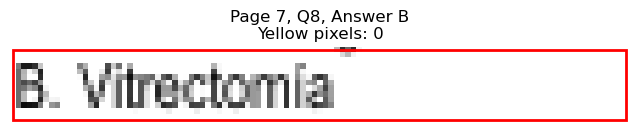

Page 7, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=380.7, y1=543.8
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 415
Page 7, Q8, C: Yellow percentage: 0.0%


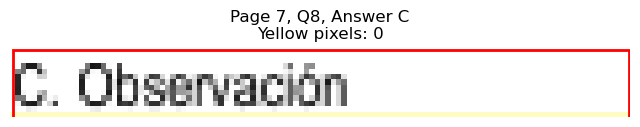

Page 7, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=398.8, y1=556.4
Page 7, Q8, D: Yellow pixels: 1400
Page 7, Q8, D: Total non-white pixels: 1876
Page 7, Q8, D: Yellow percentage: 74.6%


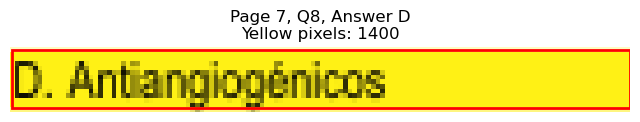


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=619.6, x1=109.5, y1=632.3
Page 7, Q9, A: Yellow pixels: 1058
Page 7, Q9, A: Total non-white pixels: 1456
Page 7, Q9, A: Yellow percentage: 72.7%


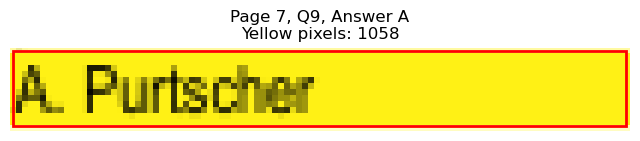

Page 7, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=110.9, y1=644.9
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 371
Page 7, Q9, B: Yellow percentage: 0.0%


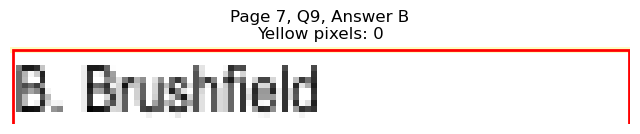

Page 7, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=364.1, y1=632.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 221
Page 7, Q9, C: Yellow percentage: 0.0%


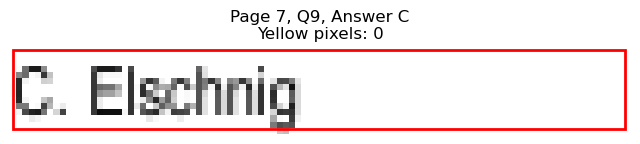

Page 7, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=360.2, y1=644.9
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 197
Page 7, Q9, D: Yellow percentage: 0.0%


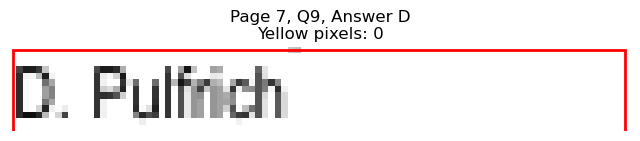


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=118.5, y1=682.7
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 304
Page 7, Q10, A: Yellow percentage: 0.0%


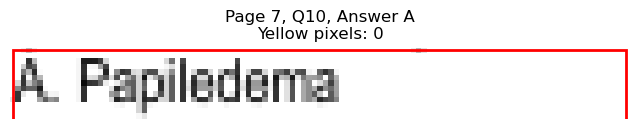

Page 7, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=217.7, y1=695.3
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 791
Page 7, Q10, B: Yellow percentage: 0.0%


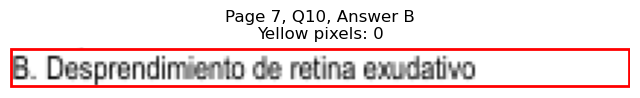

Page 7, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=423.3, y1=682.7
Page 7, Q10, C: Yellow pixels: 1656
Page 7, Q10, C: Total non-white pixels: 2067
Page 7, Q10, C: Yellow percentage: 80.1%


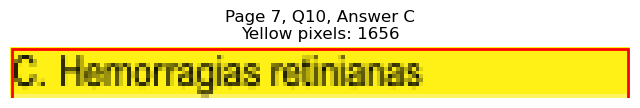

Page 7, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=413.3, y1=695.3
Page 7, Q10, D: Yellow pixels: 147
Page 7, Q10, D: Total non-white pixels: 636
Page 7, Q10, D: Yellow percentage: 23.1%


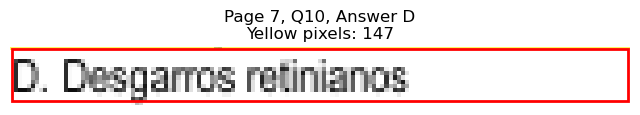


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)
Page 7, Q11 - A: Detected box: x0=56.6, y0=720.6, x1=124.9, y1=733.2
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 354
Page 7, Q11, A: Yellow percentage: 0.0%


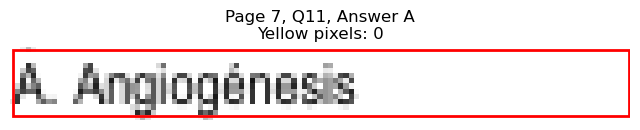

Page 7, Q11 - B: Detected box: x0=56.6, y0=733.2, x1=149.1, y1=745.8
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 434
Page 7, Q11, B: Yellow percentage: 0.0%


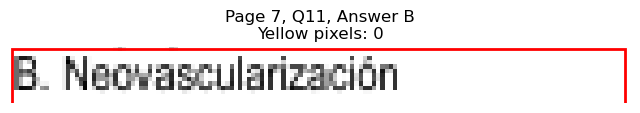

Page 7, Q11 - C: Detected box: x0=315.4, y0=720.6, x1=393.3, y1=733.2
Page 7, Q11, C: Yellow pixels: 1399
Page 7, Q11, C: Total non-white pixels: 1806
Page 7, Q11, C: Yellow percentage: 77.5%


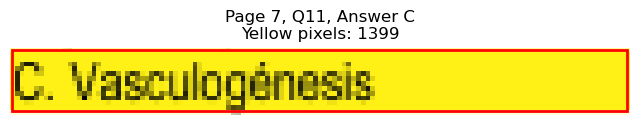

Page 7, Q11 - D: Detected box: x0=315.4, y0=733.2, x1=399.8, y1=745.8
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 575
Page 7, Q11, D: Yellow percentage: 0.0%


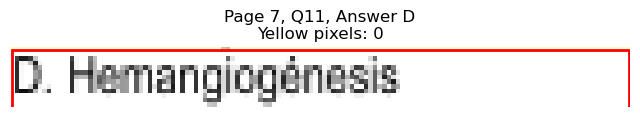


Page 7, Q11 - Selected Answer: C (based on yellow pixel count)

Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=127.5, y1=127.3
Page 8, Q1, A: Yellow pixels: 1210
Page 8, Q1, A: Total non-white pixels: 1708
Page 8, Q1, A: Yellow percentage: 70.8%


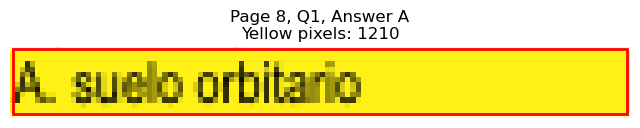

Page 8, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=123.0, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 416
Page 8, Q1, B: Yellow percentage: 0.0%


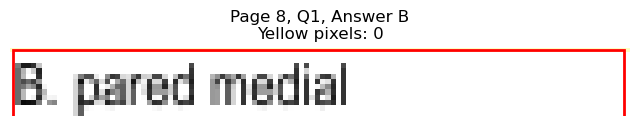

Page 8, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=387.2, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 338
Page 8, Q1, C: Yellow percentage: 0.0%


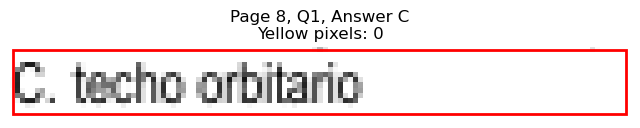

Page 8, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=380.2, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 303
Page 8, Q1, D: Yellow percentage: 0.0%


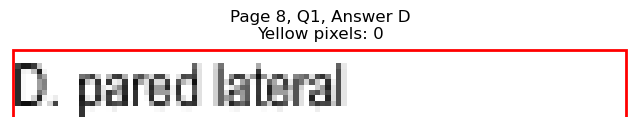


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=124.9, y1=177.8
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 441
Page 8, Q2, A: Yellow percentage: 0.0%


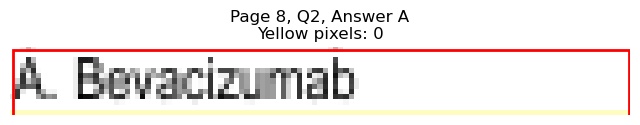

Page 8, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=119.4, y1=190.4
Page 8, Q2, B: Yellow pixels: 1117
Page 8, Q2, B: Total non-white pixels: 1596
Page 8, Q2, B: Yellow percentage: 70.0%


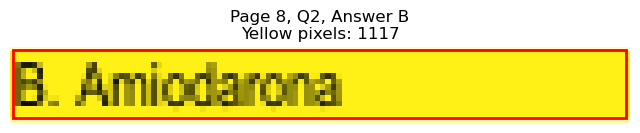

Page 8, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=388.7, y1=177.8
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 352
Page 8, Q2, C: Yellow percentage: 0.0%


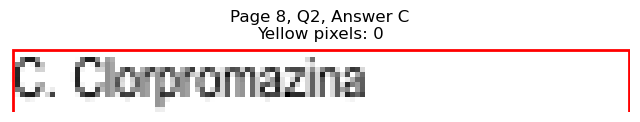

Page 8, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=370.1, y1=190.4
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 247
Page 8, Q2, D: Yellow percentage: 0.0%


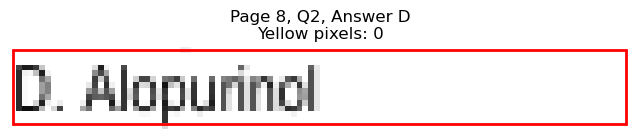


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=299.6, y1=228.3
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 1149
Page 8, Q3, A: Yellow percentage: 0.0%


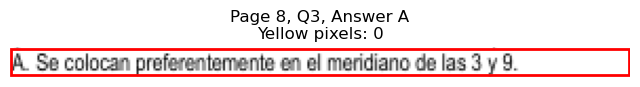

Page 8, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=434.0, y1=240.9
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 1821
Page 8, Q3, B: Yellow percentage: 0.0%


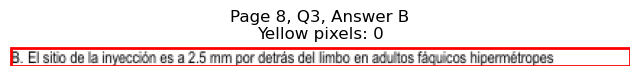

Page 8, Q3 - C: Detected box: x0=56.6, y0=240.8, x1=323.7, y1=253.5
Page 8, Q3, C: Yellow pixels: 318
Page 8, Q3, C: Total non-white pixels: 1605
Page 8, Q3, C: Yellow percentage: 19.8%


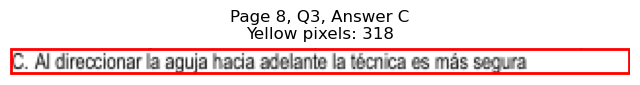

Page 8, Q3 - D: Detected box: x0=56.6, y0=253.4, x1=369.2, y1=266.1
Page 8, Q3, D: Yellow pixels: 3525
Page 8, Q3, D: Total non-white pixels: 5096
Page 8, Q3, D: Yellow percentage: 69.2%


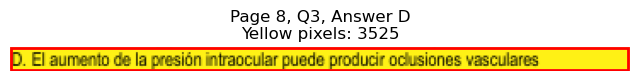


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=166.1, y1=304.0
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 510
Page 8, Q4, A: Yellow percentage: 0.0%


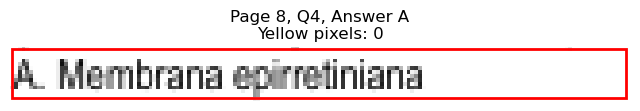

Page 8, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=162.0, y1=316.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 491
Page 8, Q4, B: Yellow percentage: 0.0%


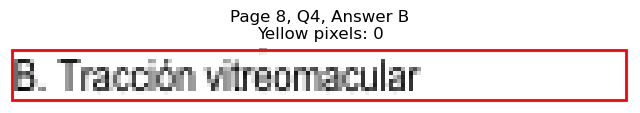

Page 8, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=393.2, y1=304.0
Page 8, Q4, C: Yellow pixels: 129
Page 8, Q4, C: Total non-white pixels: 482
Page 8, Q4, C: Yellow percentage: 26.8%


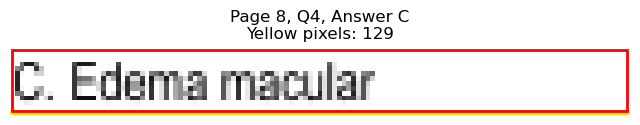

Page 8, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=395.7, y1=316.6
Page 8, Q4, D: Yellow pixels: 1405
Page 8, Q4, D: Total non-white pixels: 1703
Page 8, Q4, D: Yellow percentage: 82.5%


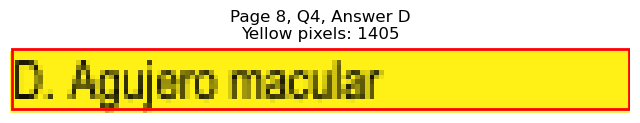


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=341.9, x1=132.1, y1=354.6
Page 8, Q5, A: Yellow pixels: 1387
Page 8, Q5, A: Total non-white pixels: 1778
Page 8, Q5, A: Yellow percentage: 78.0%


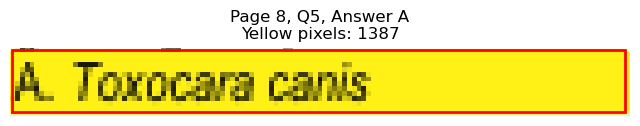

Page 8, Q5 - B: Detected box: x0=56.6, y0=354.5, x1=127.1, y1=367.1
Page 8, Q5, B: Yellow pixels: 122
Page 8, Q5, B: Total non-white pixels: 442
Page 8, Q5, B: Yellow percentage: 27.6%


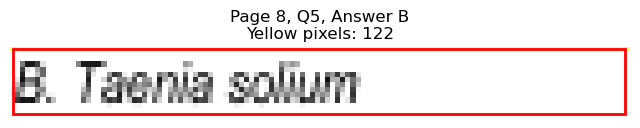

Page 8, Q5 - C: Detected box: x0=315.4, y0=341.9, x1=412.3, y1=354.5
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 458
Page 8, Q5, C: Yellow percentage: 0.0%


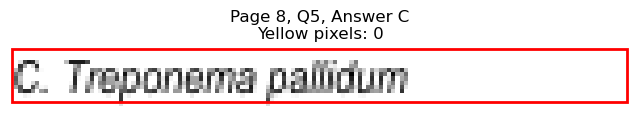

Page 8, Q5 - D: Detected box: x0=315.4, y0=354.5, x1=428.3, y1=367.1
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 567
Page 8, Q5, D: Yellow percentage: 0.0%


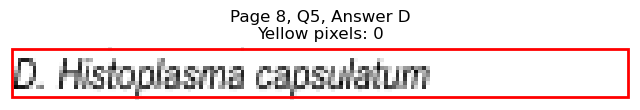


Page 8, Q5 - Selected Answer: A (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=392.3, x1=118.5, y1=405.0
Page 8, Q6, A: Yellow pixels: 1211
Page 8, Q6, A: Total non-white pixels: 1469
Page 8, Q6, A: Yellow percentage: 82.4%


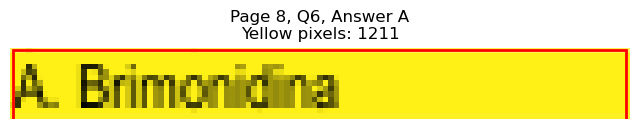

Page 8, Q6 - B: Detected box: x0=56.6, y0=404.9, x1=121.5, y1=417.6
Page 8, Q6, B: Yellow pixels: 116
Page 8, Q6, B: Total non-white pixels: 423
Page 8, Q6, B: Yellow percentage: 27.4%


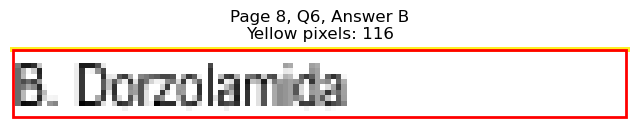

Page 8, Q6 - C: Detected box: x0=315.4, y0=392.3, x1=377.7, y1=405.0
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 285
Page 8, Q6, C: Yellow percentage: 0.0%


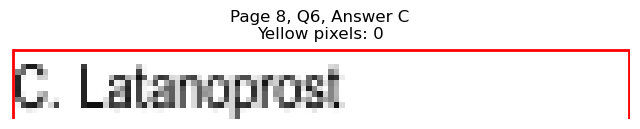

Page 8, Q6 - D: Detected box: x0=315.4, y0=404.9, x1=359.1, y1=417.6
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 197
Page 8, Q6, D: Yellow percentage: 0.0%


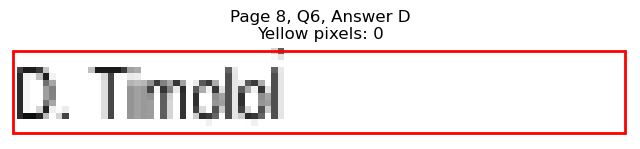


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=442.8, x1=181.7, y1=455.5
Page 8, Q7, A: Yellow pixels: 176
Page 8, Q7, A: Total non-white pixels: 792
Page 8, Q7, A: Yellow percentage: 22.2%


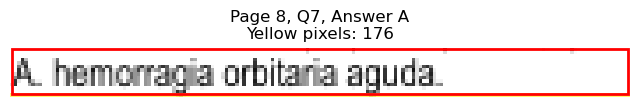

Page 8, Q7 - B: Detected box: x0=56.6, y0=455.5, x1=173.7, y1=468.1
Page 8, Q7, B: Yellow pixels: 1738
Page 8, Q7, B: Total non-white pixels: 2352
Page 8, Q7, B: Yellow percentage: 73.9%


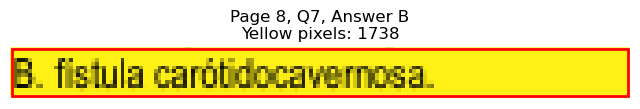

Page 8, Q7 - C: Detected box: x0=315.4, y0=442.8, x1=452.5, y1=455.5
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 647
Page 8, Q7, C: Yellow percentage: 0.0%


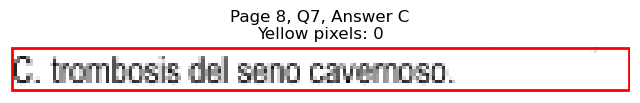

Page 8, Q7 - D: Detected box: x0=315.4, y0=455.5, x1=430.9, y1=468.1
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 579
Page 8, Q7, D: Yellow percentage: 0.0%


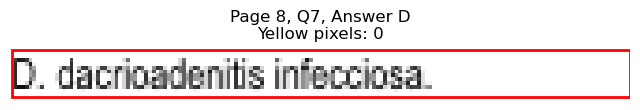


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=122.4, y1=543.8
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 322
Page 8, Q8, A: Yellow percentage: 0.0%


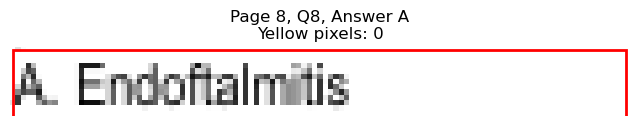

Page 8, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=139.6, y1=556.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 399
Page 8, Q8, B: Yellow percentage: 0.0%


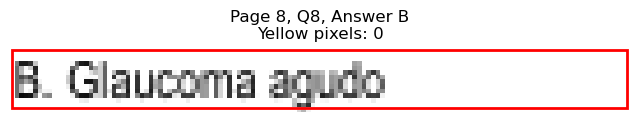

Page 8, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=371.7, y1=543.8
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 389
Page 8, Q8, C: Yellow percentage: 0.0%


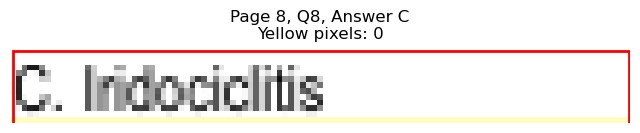

Page 8, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=403.7, y1=556.4
Page 8, Q8, D: Yellow pixels: 1460
Page 8, Q8, D: Total non-white pixels: 1946
Page 8, Q8, D: Yellow percentage: 75.0%


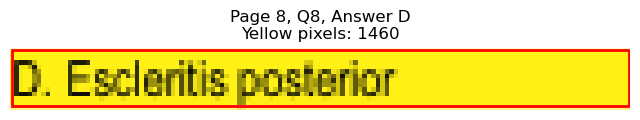


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=103.5, y1=619.5
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 218
Page 8, Q9, A: Yellow percentage: 0.0%


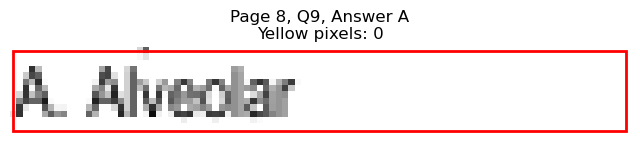

Page 8, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=119.4, y1=632.3
Page 8, Q9, B: Yellow pixels: 1117
Page 8, Q9, B: Total non-white pixels: 1596
Page 8, Q9, B: Yellow percentage: 70.0%


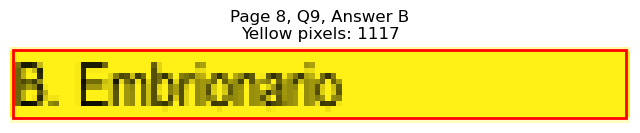

Page 8, Q9 - C: Detected box: x0=315.4, y0=606.9, x1=371.2, y1=619.5
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 241
Page 8, Q9, C: Yellow percentage: 0.0%


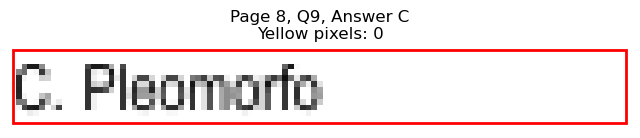

Page 8, Q9 - D: Detected box: x0=315.4, y0=619.6, x1=365.7, y1=632.3
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 253
Page 8, Q9, D: Yellow percentage: 0.0%


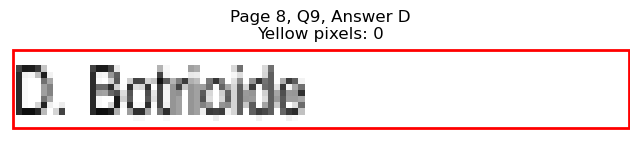


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=296.9, y1=682.7
Page 8, Q10, A: Yellow pixels: 2794
Page 8, Q10, A: Total non-white pixels: 3783
Page 8, Q10, A: Yellow percentage: 73.9%


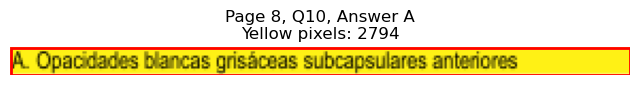

Page 8, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=282.4, y1=695.3
Page 8, Q10, B: Yellow pixels: 275
Page 8, Q10, B: Total non-white pixels: 1410
Page 8, Q10, B: Yellow percentage: 19.5%


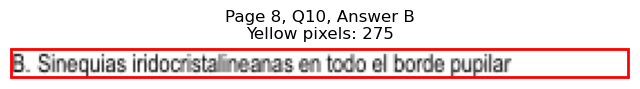

Page 8, Q10 - C: Detected box: x0=56.6, y0=695.4, x1=294.9, y1=708.0
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 1144
Page 8, Q10, C: Yellow percentage: 0.0%


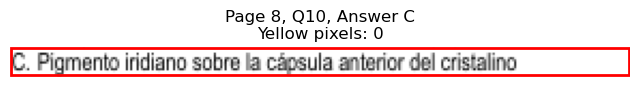

Page 8, Q10 - D: Detected box: x0=56.6, y0=708.0, x1=293.4, y1=720.6
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 1196
Page 8, Q10, D: Yellow percentage: 0.0%


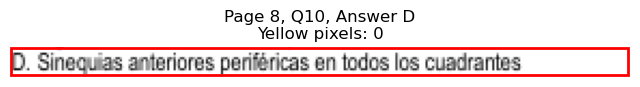


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)

Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=75.9, y1=127.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 69
Page 9, Q1, A: Yellow percentage: 0.0%


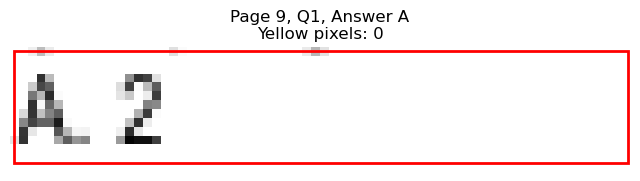

Page 9, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=75.9, y1=139.9
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 60
Page 9, Q1, B: Yellow percentage: 0.0%


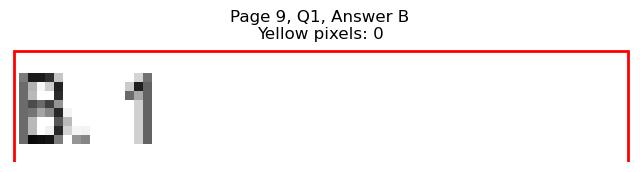

Page 9, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=335.1, y1=127.3
Page 9, Q1, C: Yellow pixels: 71
Page 9, Q1, C: Total non-white pixels: 136
Page 9, Q1, C: Yellow percentage: 52.2%


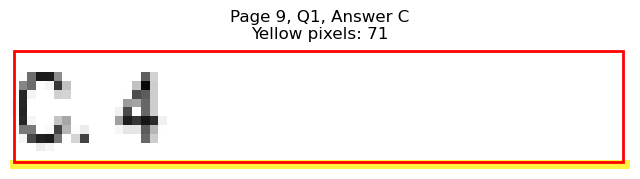

Page 9, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=335.1, y1=139.9
Page 9, Q1, D: Yellow pixels: 874
Page 9, Q1, D: Total non-white pixels: 923
Page 9, Q1, D: Yellow percentage: 94.7%


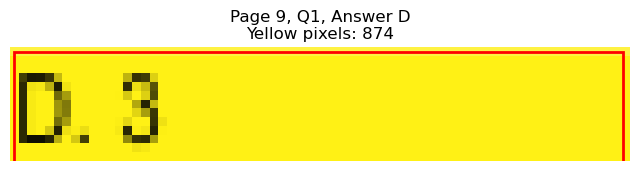


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=106.5, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 230
Page 9, Q2, A: Yellow percentage: 0.0%


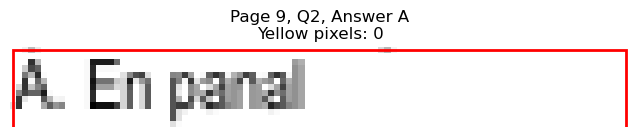

Page 9, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=143.5, y1=190.4
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 423
Page 9, Q2, B: Yellow percentage: 0.0%


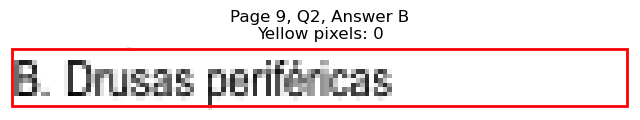

Page 9, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=389.7, y1=177.8
Page 9, Q2, C: Yellow pixels: 1361
Page 9, Q2, C: Total non-white pixels: 1625
Page 9, Q2, C: Yellow percentage: 83.8%


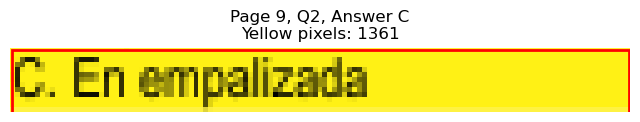

Page 9, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=382.3, y1=190.4
Page 9, Q2, D: Yellow pixels: 118
Page 9, Q2, D: Total non-white pixels: 441
Page 9, Q2, D: Yellow percentage: 26.8%


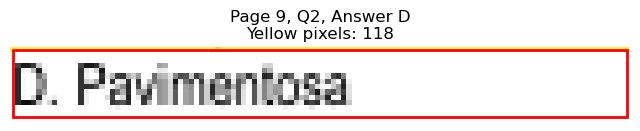


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=278.0, y1=228.3
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 1127
Page 9, Q3, A: Yellow percentage: 0.0%


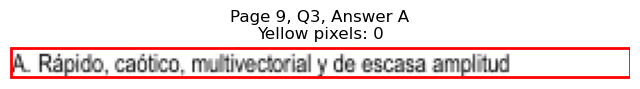

Page 9, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=270.4, y1=240.9
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 1313
Page 9, Q3, B: Yellow percentage: 0.0%


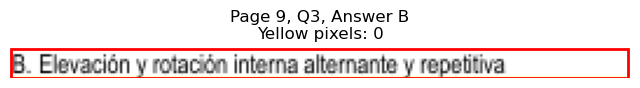

Page 9, Q3 - C: Detected box: x0=56.6, y0=240.8, x1=254.0, y1=253.5
Page 9, Q3, C: Yellow pixels: 2475
Page 9, Q3, C: Total non-white pixels: 3472
Page 9, Q3, C: Yellow percentage: 71.3%


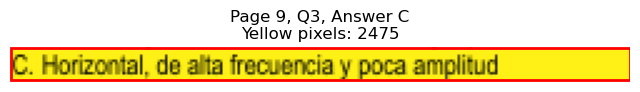

Page 9, Q3 - D: Detected box: x0=56.6, y0=253.4, x1=292.0, y1=266.1
Page 9, Q3, D: Yellow pixels: 287
Page 9, Q3, D: Total non-white pixels: 1407
Page 9, Q3, D: Yellow percentage: 20.4%


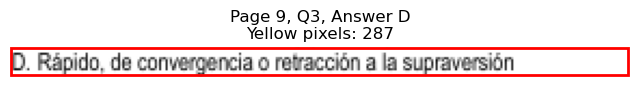


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=185.2, y1=316.6
Page 9, Q4, A: Yellow pixels: 1
Page 9, Q4, A: Total non-white pixels: 807
Page 9, Q4, A: Yellow percentage: 0.1%


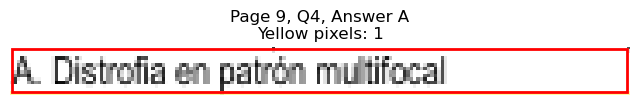

Page 9, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=172.1, y1=329.2
Page 9, Q4, B: Yellow pixels: 1536
Page 9, Q4, B: Total non-white pixels: 2338
Page 9, Q4, B: Yellow percentage: 65.7%


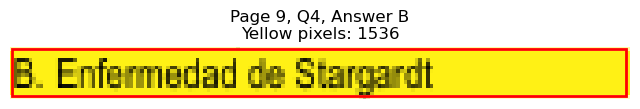

Page 9, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=412.3, y1=316.6
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 464
Page 9, Q4, C: Yellow percentage: 0.0%


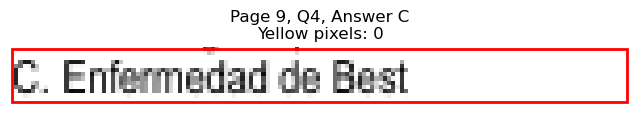

Page 9, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=450.4, y1=329.2
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 675
Page 9, Q4, D: Yellow percentage: 0.0%


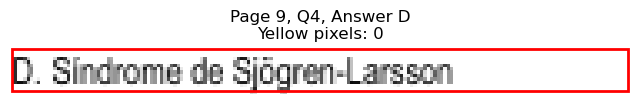


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=93.9, y1=367.2
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 176
Page 9, Q5, A: Yellow percentage: 0.0%


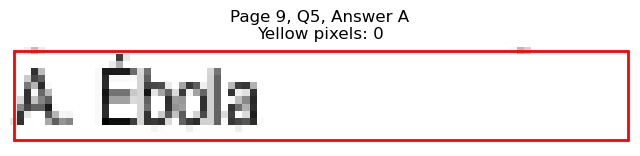

Page 9, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=123.5, y1=379.8
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 299
Page 9, Q5, B: Yellow percentage: 0.0%


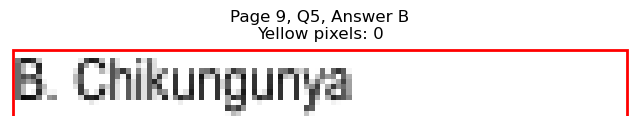

Page 9, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=359.1, y1=367.2
Page 9, Q5, C: Yellow pixels: 1070
Page 9, Q5, C: Total non-white pixels: 1330
Page 9, Q5, C: Yellow percentage: 80.5%


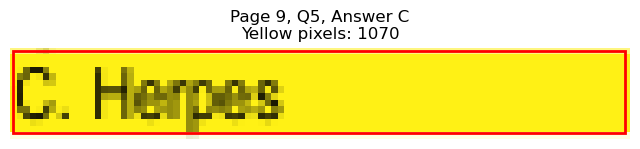

Page 9, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=361.6, y1=379.8
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 321
Page 9, Q5, D: Yellow percentage: 0.0%


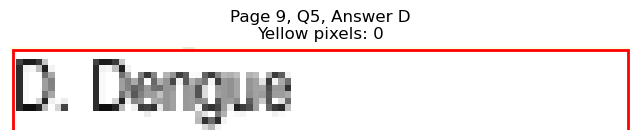


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=275.4, y1=430.3
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 1105
Page 9, Q6, A: Yellow percentage: 0.0%


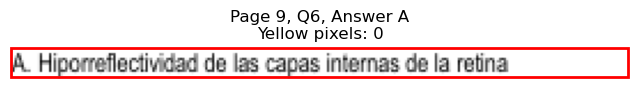

Page 9, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=167.1, y1=442.9
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 677
Page 9, Q6, B: Yellow percentage: 0.0%


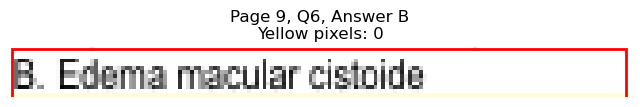

Page 9, Q6 - C: Detected box: x0=56.6, y0=442.8, x1=278.4, y1=455.5
Page 9, Q6, C: Yellow pixels: 2724
Page 9, Q6, C: Total non-white pixels: 3822
Page 9, Q6, C: Yellow percentage: 71.3%


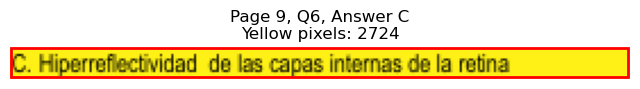

Page 9, Q6 - D: Detected box: x0=56.6, y0=455.5, x1=144.0, y1=468.1
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 426
Page 9, Q6, D: Yellow percentage: 0.0%


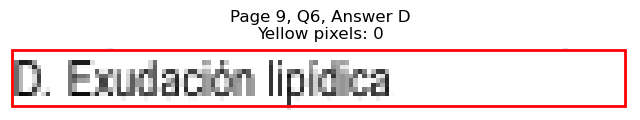


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=109.5, y1=518.6
Page 9, Q7, A: Yellow pixels: 1175
Page 9, Q7, A: Total non-white pixels: 1456
Page 9, Q7, A: Yellow percentage: 80.7%


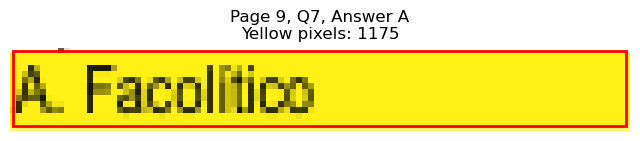

Page 9, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=136.0, y1=531.2
Page 9, Q7, B: Yellow pixels: 130
Page 9, Q7, B: Total non-white pixels: 522
Page 9, Q7, B: Yellow percentage: 24.9%


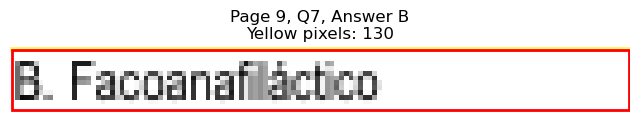

Page 9, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=379.7, y1=518.6
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 288
Page 9, Q7, C: Yellow percentage: 0.0%


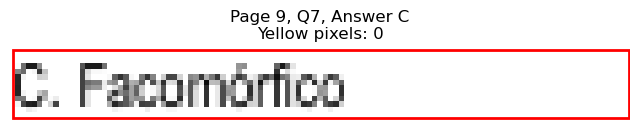

Page 9, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=373.7, y1=531.2
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 273
Page 9, Q7, D: Yellow percentage: 0.0%


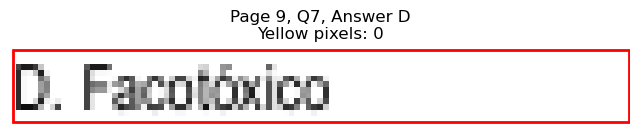


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=197.2, y1=569.1
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 676
Page 9, Q8, A: Yellow percentage: 0.0%


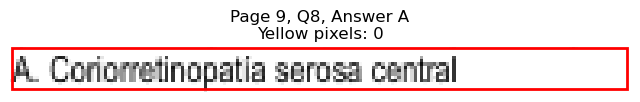

Page 9, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=176.2, y1=581.7
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 586
Page 9, Q8, B: Yellow percentage: 0.0%


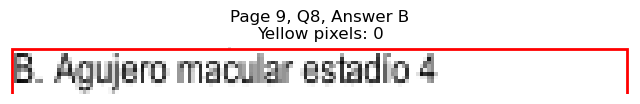

Page 9, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=424.9, y1=569.1
Page 9, Q8, C: Yellow pixels: 1686
Page 9, Q8, C: Total non-white pixels: 2240
Page 9, Q8, C: Yellow percentage: 75.3%


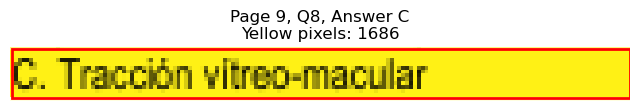

Page 9, Q8 - D: Detected box: x0=315.4, y0=569.1, x1=431.8, y1=581.7
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 732
Page 9, Q8, D: Yellow percentage: 0.0%


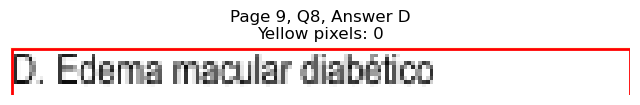


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=670.0, x1=197.8, y1=682.7
Page 9, Q9, A: Yellow pixels: 2
Page 9, Q9, A: Total non-white pixels: 915
Page 9, Q9, A: Yellow percentage: 0.2%


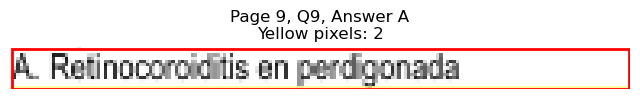

Page 9, Q9 - B: Detected box: x0=56.6, y0=682.6, x1=227.8, y1=695.3
Page 9, Q9, B: Yellow pixels: 2002
Page 9, Q9, B: Total non-white pixels: 3108
Page 9, Q9, B: Yellow percentage: 64.4%


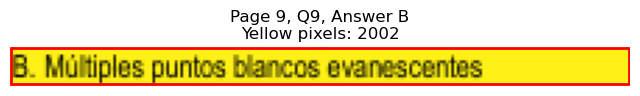

Page 9, Q9 - C: Detected box: x0=315.4, y0=670.0, x1=452.0, y1=682.7
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 686
Page 9, Q9, C: Yellow percentage: 0.0%


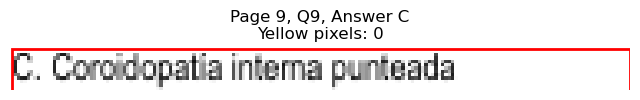

Page 9, Q9 - D: Detected box: x0=315.4, y0=682.6, x1=503.6, y1=695.3
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 943
Page 9, Q9, D: Yellow percentage: 0.0%


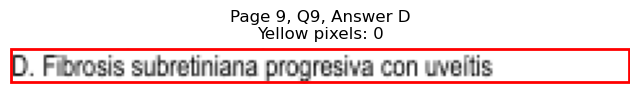


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)
Page 9, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=181.1, y1=745.8
Page 9, Q10, A: Yellow pixels: 1828
Page 9, Q10, A: Total non-white pixels: 2288
Page 9, Q10, A: Yellow percentage: 79.9%


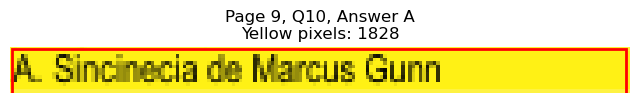

Page 9, Q10 - B: Detected box: x0=56.6, y0=745.8, x1=267.5, y1=758.4
Page 9, Q10, B: Yellow pixels: 225
Page 9, Q10, B: Total non-white pixels: 1288
Page 9, Q10, B: Yellow percentage: 17.5%


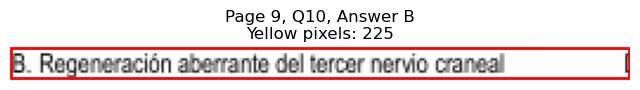

Page 9, Q10 - C: Detected box: x0=315.4, y0=733.2, x1=411.8, y1=745.8
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 456
Page 9, Q10, C: Yellow percentage: 0.0%


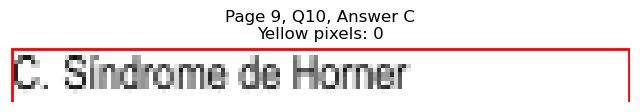

Page 9, Q10 - D: Detected box: x0=315.4, y0=745.8, x1=447.5, y1=758.4
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 644
Page 9, Q10, D: Yellow percentage: 0.0%


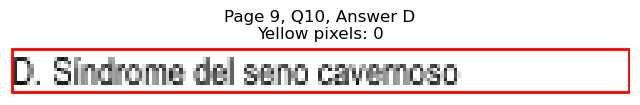


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)

Page 10: Found 3 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=94.8, y1=114.7
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 258
Page 10, Q1, A: Yellow percentage: 0.0%


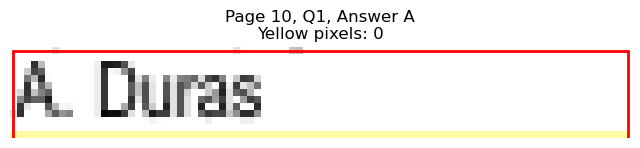

Page 10, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=109.9, y1=127.3
Page 10, Q1, B: Yellow pixels: 1023
Page 10, Q1, B: Total non-white pixels: 1456
Page 10, Q1, B: Yellow percentage: 70.3%


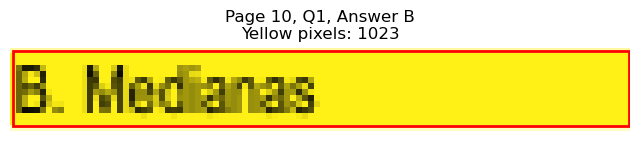

Page 10, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=362.7, y1=114.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 200
Page 10, Q1, C: Yellow percentage: 0.0%


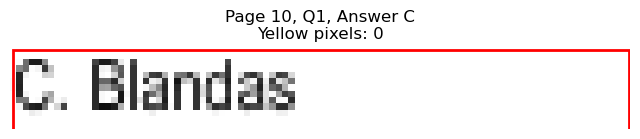

Page 10, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=375.2, y1=127.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 289
Page 10, Q1, D: Yellow percentage: 0.0%


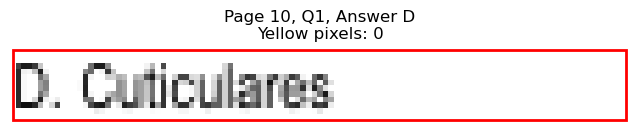


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=188.7, y1=165.2
Page 10, Q2, A: Yellow pixels: 183
Page 10, Q2, A: Total non-white pixels: 783
Page 10, Q2, A: Yellow percentage: 23.4%


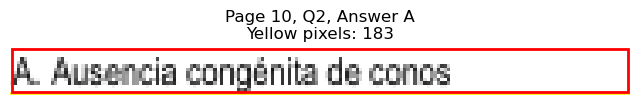

Page 10, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=139.6, y1=177.8
Page 10, Q2, B: Yellow pixels: 1406
Page 10, Q2, B: Total non-white pixels: 1742
Page 10, Q2, B: Yellow percentage: 80.7%


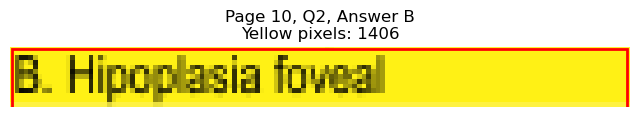

Page 10, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=440.3, y1=165.2
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 618
Page 10, Q2, C: Yellow percentage: 0.0%


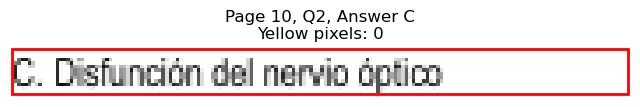

Page 10, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=403.7, y1=177.8
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 458
Page 10, Q2, D: Yellow percentage: 0.0%


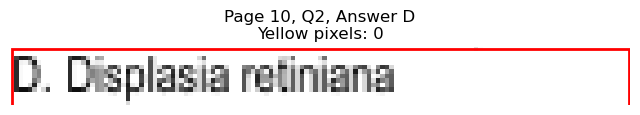


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=202.9, x1=197.2, y1=215.6
Page 10, Q3, A: Yellow pixels: 1956
Page 10, Q3, A: Total non-white pixels: 2688
Page 10, Q3, A: Yellow percentage: 72.8%


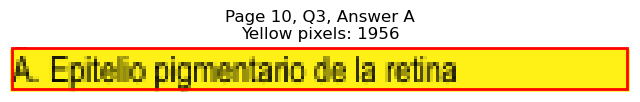

Page 10, Q3 - B: Detected box: x0=56.6, y0=215.6, x1=152.5, y1=228.3
Page 10, Q3, B: Yellow pixels: 145
Page 10, Q3, B: Total non-white pixels: 591
Page 10, Q3, B: Yellow percentage: 24.5%


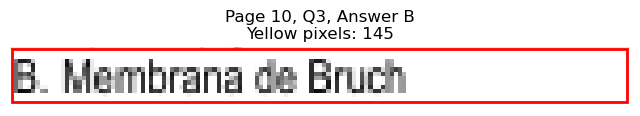

Page 10, Q3 - C: Detected box: x0=315.4, y0=202.9, x1=384.7, y1=215.6
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 346
Page 10, Q3, C: Yellow percentage: 0.0%


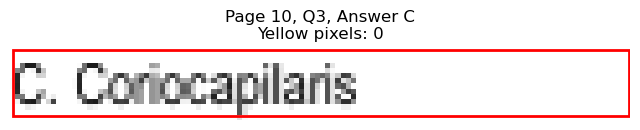

Page 10, Q3 - D: Detected box: x0=315.4, y0=215.6, x1=467.5, y1=228.3
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 718
Page 10, Q3, D: Yellow percentage: 0.0%


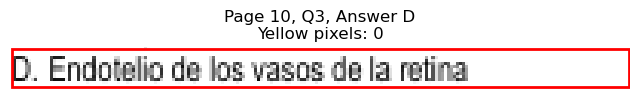


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 24 años con hepatopatía inespecífica,...
1   ¿Cuál de los siguientes quistes es un hidrocis...
2   Mujer de 70 años, PO3 de catarata. Examen: len...
3   ¿Cuál es el patrón de herencia de la neuropatí...
4   Varón de 18 años con hipoacusia neurosensorial...
..                                                ...
95  Mujer de 28 años acudió por disminución súbita...
96  ¿En qué patología se produce la retracción del...
97  ¿Cuál de los siguientes tipos de drusas se def...
98  ¿Cuál es la causa de la disminución de la visi...
99  ¿Cuál se considera barrera hematorretiniana ex...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                     α1- antitripsina   
1                              De Zeis   
2        Análogos de la prostaglandina   
3   De mutaciones del ADN mitocondrial   
4                    Luxación superior   
..                                 ...   
95     Retinocoroiditis en perdigonada   
96           Sincinecia de Marcus Gunn   
97                               Duras   
98         Ausencia congénita de conos   
99   Epitelio pigmentario de la retina   

                                            option_B  \
0                                     Ceruloplasmina   
1                                            De Moll   
2                     Betabloqueadores no selectivos   
3                   Ligado a cromosoma X (dominante)   
4                     Catarata “en árbol de navidad”   
..                                               ...   
95             Múltiples puntos blancos evanescentes   
96  Regeneración aberrante del tercer nervio craneal   
97                                          Medianas   
98                                 Hipoplasia foveal   
99                                 Membrana de Bruch   

                                 option_C  \
0                               Ferritina   
1                                  Miliar   
2   Inhibidores de la anhidrasa carbónica   
3               Por mutación del gen PAX6   
4            Catarata “en gota de aceite”   
..                                    ...   
95          Coroidopatía interna punteada   
96                     Síndrome de Horner   
97                                Blandas   
98           Disfunción del nervio óptico   
99                         Coriocapilaris   

                                        option_D  
0                                        Tiamina  
1                                       Dermoide  
2                 Agentes parasimpaticomiméticos  
3                Ligado a cromosoma X (recesivo)  
4                             Lenticono anterior  
..                                           ...  
95  Fibrosis subretiniana progresiva con uveítis  
96                   Síndrome del seno cavernoso  
97                                   Cuticulares  
98                           Displasia retiniana  
99           Endotelio de los vasos de la retina  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 24 años con hepatopatía inespecífica,...   
1   ¿Cuál de los siguientes quistes es un hidrocis...   
2   Mujer de 70 años, PO3 de catarata. Examen: len...   
3   ¿Cuál es el patrón de herencia de la neuropatí...   
4   Varón de 18 años con hipoacusia neurosensorial...   
..                                                ...   
95  Mujer de 28 años acudió por disminución súbita...   
96  ¿En qué patología se produce la retracción del...   
97  ¿Cuál de los siguientes tipos de drusas se def...   
98  ¿Cuál es la causa de la disminución de la visi...   
99  ¿Cuál se considera barrera hematorretiniana ex...   

                              option_A  \
0                     α1- antitripsina   
1                              De Zeis   
2        Análogos de la prostaglandina   
3   De mutaciones del ADN mitocondrial   
4                    Luxación superior   
..                                 ...   
95     Retinocoroiditis en perdigonada   
96           Sincinecia de Marcus Gunn   
97                               Duras   
98         Ausencia congénita de conos   
99   Epitelio pigmentario de la retina   

                                            option_B  \
0                                     Ceruloplasmina   
1                                            De Moll   
2                     Betabloqueadores no selectivos   
3                   Ligado a cromosoma X (dominante)   
4                     Catarata “en árbol de navidad”   
..                                               ...   
95             Múltiples puntos blancos evanescentes   
96  Regeneración aberrante del tercer nervio craneal   
97                                          Medianas   
98                                 Hipoplasia foveal   
99                                 Membrana de Bruch   

                                 option_C  \
0                               Ferritina   
1                                  Miliar   
2   Inhibidores de la anhidrasa carbónica   
3               Por mutación del gen PAX6   
4            Catarata “en gota de aceite”   
..                                    ...   
95          Coroidopatía interna punteada   
96                     Síndrome de Horner   
97                                Blandas   
98           Disfunción del nervio óptico   
99                         Coriocapilaris   

                                        option_D correct_answer  
0                                        Tiamina              B  
1                                       Dermoide              B  
2                 Agentes parasimpaticomiméticos              A  
3                Ligado a cromosoma X (recesivo)              A  
4                             Lenticono anterior              D  
..                                           ...            ...  
95  Fibrosis subretiniana progresiva con uveítis              B  
96                   Síndrome del seno cavernoso              A  
97                                   Cuticulares              B  
98                           Displasia retiniana              B  
99           Endotelio de los vasos de la retina              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/OFTALMOLOGÍA.csv
